# Exploratory Data Analysis of Voting History of the Compound Governance Protocol

**[Johnnatan Messias](https://johnnatan-messias.github.io/), March 2025**

We analyzed the voting history of the Compound Governance Protocol by gathering data from the Ethereum blockchain. This data, collected through an Archive Node, includes all voting history and transfers related to Compound from March 4th, 2020 (starting at block number 9,601,459) to August 19th, 2024 (up to block number 20,563,000).

**Compound dataset**: **Token: COMP**

| Event Name           | # of Events | Description                                                                                                                                                                                                                                                                                                                                                                                                                    |
| -------------------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| Approval             | 256,032     | Standard ERC-20 approval event.                                                                                                                                                                                                                                                                                                                                                                                                |
| DelegateChanged      | 15,244      | Emitted when an account changes its delegate. This means that the delegatee will receive voting power from the sender. Users can only delegate to one address at a time, and the number of votes added to the delegatee’s vote count is equal to the user’s token balance. The delegation of votes will take effect from the current block until the sender either delegates to a different address or transfers their tokens. |
| DelegateVotesChanged | 83,798      | Emitted when a delegate account's vote balance changes.                                                                                                                                                                                                                                                                                                                                                                        |
| Transfer             | 2,224,966   | Emitted when users/holders transfer their tokens to another address.                                                                                                                                                                                                                                                                                                                                                           |

**Governor**

| Event Name       | # of Events | Description                                                                                  |
| ---------------- | ----------- | -------------------------------------------------------------------------------------------- |
| ProposalCanceled | 30          | Emitted when a proposal is canceled.                                                         |
| ProposalCreated  | 307         | Emitted when a new proposal is created.                                                      |
| ProposalExecuted | 238         | Emitted when a proposal is executed in the TimeLock.                                         |
| ProposalQueued   | 246         | Emitted when a proposal is added to the queue in the TimeLock.                               |
| VoteCast         | 14,841      | Emitted when a vote is cast on a proposal: 0 for against, 1 for in-favor, and 2 for abstain. |


In [1]:
import os
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

In [3]:
proposal_quorum = 0.04 * 10e6  # 4% of total supply
protocol_name = 'compound'
dynamic_chart = True
plot_style = 'png' if not dynamic_chart else None

In [4]:
from plot_utils import get_plotly_layout
from plot_utils import colors
import plotly.graph_objects as go
from plotly import express as px
from utils import load_dataframes
width, height = 850, 450

In [5]:
# Set directory paths
data_dir = os.path.abspath(
    os.path.join(os.getcwd(), "..", "data")) + os.sep
plots_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "plots")) + os.sep

# Create directories if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

In [6]:
dfs = load_dataframes(path_dir=data_dir+protocol_name+os.sep)
for filename in dfs:
    print("Dataframe {} loaded".format(filename))

Loading dataframes: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]

Dataframe supporters_df loaded
Dataframe approval_df loaded
Dataframe proposal_cancelled_df loaded
Dataframe delegatechanged_df loaded
Dataframe proposal_voting_period_df loaded
Dataframe proposals_queued_df loaded
Dataframe proposal_voting_delay_df loaded
Dataframe delegatevoteschanged_df loaded
Dataframe transfer_df loaded
Dataframe votes_weighted_df loaded
Dataframe proposal_created_df loaded
Dataframe votes_df loaded
Dataframe proposal_executed_df loaded


## Loading Labels


In [7]:
labels_dir = os.path.join(data_dir, "labels")
with open(os.path.join(labels_dir, "labels.json")) as f:
    labels = json.load(f)
print("Labels loaded: {}".format(len(labels)))

Labels loaded: 29738


## Loading Variables


In [8]:
supporters_df = dfs['supporters_df']
proposal_cancelled_df = dfs['proposal_cancelled_df']
# proposal_voting_period_df = dfs['proposal_voting_period_df']
proposals_queued_df = dfs['proposals_queued_df']
votes_weighted_df = dfs['votes_weighted_df']
proposal_created_df = dfs['proposal_created_df']
votes_df = dfs['votes_df']
proposal_executed_df = dfs['proposal_executed_df']
# proposal_voting_delay_df = dfs['proposal_voting_delay_df']

## Exploratory Data Analysis


### Basic Statistics


In [9]:
print("In this dataset, there are {} unique proposals created by {} unique proposers".format(
    proposal_created_df.proposalId.nunique(), proposal_created_df.proposer.nunique()))
print("\tThere are {} proposals executed".format(
    proposal_executed_df.proposalId.nunique()))
print("\tThere are {} proposals queued".format(
    proposals_queued_df.proposalId.nunique()))
print("\tThere are {} proposals canceled".format(
    proposal_cancelled_df.proposalId.nunique()))
# print("\tThere are {} Voting Period change".format(
#     proposal_voting_period_df.shape[0]))
# print("\tThere are {} unique Voting Delay Change".format(
#     proposal_voting_delay_df.shape[0]))

print("There are {} unique voters who have casted {} votes".format(
    votes_df.voter.nunique(), votes_df.shape[0]))

print("Votes were cast trough {} unique transactions".format(
    votes_df.transactionHash.nunique()))

# Empty voting power
print("There are {} votes with 0 voting power".format(
    votes_df.query('votes == 0').shape[0]))

In this dataset, there are 307 unique proposals created by 45 unique proposers
	There are 238 proposals executed
	There are 246 proposals queued
	There are 30 proposals canceled
There are 4538 unique voters who have casted 14841 votes
Votes were cast trough 13926 unique transactions
There are 2463 votes with 0 voting power


In [10]:
# Proposal creation distribution
data = pd.concat([proposal_created_df['proposer'].value_counts(), proposal_created_df['proposer'].value_counts(
    normalize=True)], axis=1, keys=['count', 'percentage']).reset_index()
data['proposer_label'] = data['proposer'].apply(
    lambda x: labels.get(x, x[:6]+"..."+x[-4:]))
display(data['count'].describe().to_frame().T)
data.head()

count      mean        std  min  25%  50%  75%   max
count   45.0  6.822222  13.230971  1.0  1.0  2.0  8.0  83.0

proposer  count  percentage  \
0  0x683a4f9915d6216f73d6df50151725036bd26c02     83    0.270358   
1  0x7b3c54e17d618cc94dadfe7671c1e2f50c4ecc33     32    0.104235   
2  0x54a37d93e57c5da659f508069cf65a381b61e189     20    0.065147   
3  0x3fb19771947072629c8eee7995a2ef23b72d4c8a     17    0.055375   
4  0xc66e426404c742d81655a9d80ce58fdbcee468a9     16    0.052117   

  proposer_label  
0       Gauntlet  
1  0x7b3c...cc33  
2           blck  
3           PGov  
4  0xc66e...68a9

In [11]:
data.query('count >= 8').shape[0]

12

In [12]:
# Votes distribution
data = pd.concat([votes_df.support.value_counts(), votes_df.support.value_counts(
    normalize=True)], axis=1, keys=['count', 'percentage'])
data

count  percentage
support                   
1        13837    0.932350
0          858    0.057813
2          146    0.009838

In [13]:
# Number of proposals votes by each voter
votes_df.voter.value_counts().describe(
    percentiles=[0.25, 0.5, 0.5250, 0.75, 0.9, 0.95, 0.99])

count    4538.000000
mean        3.270383
std         9.207155
min         1.000000
25%         1.000000
50%         1.000000
52.5%       1.000000
75%         3.000000
90%         6.000000
95%         8.000000
99%        32.000000
max       192.000000
Name: count, dtype: float64

In [14]:
# Distribution of the number of proposals voted by each voter
votes_df.proposalId.value_counts().describe()

count    293.000000
mean      50.651877
std       71.717637
min        1.000000
25%       18.000000
50%       29.000000
75%       52.000000
max      619.000000
Name: count, dtype: float64

In [15]:
# Top proposals with the maximum number of voters
votes_df.proposalId.value_counts().head()

proposalId
111    619
115    579
105    404
131    368
109    341
Name: count, dtype: int64

In [16]:
# Status of the proposals outcome.
votes_weighted_df.status.value_counts()

status
executed    241
defeated     36
canceled     30
Name: count, dtype: int64

In [17]:
# Proposals defeated by the community
proposals_defeated_df = votes_weighted_df.query(
    'status == "defeated"').sort_values(by='proposalId', ascending=True)
print("There are {} proposals defeated by the community".format(
    proposals_defeated_df.proposalId.nunique()))
proposals_defeated_df.head()

There are 36 proposals defeated by the community


proposalId        against       in_favor        abstain       n_votes  \
11          12  538486.083105  133613.887401       0.000000  6.721000e+05   
13          14  669872.816464  353204.756027       0.000000  1.023078e+06   
31          32  681290.374861  212952.205095       0.000000  8.942426e+05   
37          38    5000.053175  259279.753184       0.000000  2.642798e+05   
66          67  279499.278763  121013.025546  182562.700737  5.830750e+05   

    against_percentage  in_favor_percentage  abstain_percentage  \
11           80.119939            19.880061            0.000000   
13           65.476249            34.523751            0.000000   
31           76.186304            23.813696            0.000000   
37            1.891954            98.108046            0.000000   
66           47.935390            20.754281           31.310329   

    supporter_against  supporter_in_favor  ...  supporter_against_percentage  \
11               48.0                58.0  ...                     45.283019   
13               39.0                85.0  ...                     31.451613   
31               27.0                25.0  ...                     51.923077   
37                2.0                17.0  ...                     10.526316   
66                8.0                16.0  ...                     29.629630   

    supporter_in_favor_percentage  supporter_abstain_percentage  \
11                      54.716981                      0.000000   
13                      68.548387                      0.000000   
31                      48.076923                      0.000000   
37                      89.473684                      0.000000   
66                      59.259259                     11.111111   

                                      proposer  blockNumber  \
11  0x7e4a8391c728fed9069b2962699ab416628b19fa     10375086   
13  0x9695cfaa368718dd6790a6f57b633d83f565893e     10401005   
31  0x2f04664b18fb9b6d49124fcc876b52a4ba797718     11434044   
37  0x6626593c237f530d15ae9980a95ef938ac15c35c     11837564   
66  0xc8a69971daa3c3add85ab0d0af297515769ddffc     13541005   

                                      transactionHash  \
11  ec6cddd238e8ec8b12c44dc2dadcdd315da21586713e34...   
13  15218a54eb95715d5ec986aaf05f827c2795d895fe2eff...   
31  ab9dfd2e6a998ff5093f3e81bb3bc2840cd6da819b49a2...   
37  80f138c6c191b8360d09bd238325b9fb6d00a624040ed4...   
66  bb0f58cf06878cfbae41b74f3c26949920366ddbdfc887...   

                                       proposal_title    status    number  \
11                    Update cDAI Interest Rate Model  defeated  10375086   
13                  Set WBTC Collateral Factor to 65%  defeated  10401005   
31  Distribute COMP to Affected Users in the DAI L...  defeated  11434044   
37                 Adjust BAT, ZRX collateral factors  defeated  11837564   
66  [Temp. Check] Should Compound retroactively di...  defeated  13541005   

             timestamp  
11 2020-07-01 18:14:53  
13 2020-07-05 18:29:49  
31 2020-12-11 21:17:06  
37 2021-02-11 20:54:06  
66 2021-11-03 01:34:38  

[5 rows x 22 columns]

In [18]:
# How many proposals were defeated just because they did not reached quorum.
proposals_defeated_df.query("in_favor < @proposal_quorum").shape

(35, 22)

### Proposals


In [19]:
proposals_created_timestamp_df = votes_weighted_df[['proposalId', 'blockNumber', 'status', 'timestamp']].rename(
    columns={'timestamp': 'proposal_created_timestamp'}).sort_values(by='proposal_created_timestamp')

display(((proposals_created_timestamp_df['proposal_created_timestamp'].diff(
).dt.total_seconds().describe())/3600/24).to_frame().T)

maker_colors = {'executed': colors['green'],
                'defeated': colors['red'], 'canceled': colors['blue']}

markers = {'executed': 'circle', 'defeated': 'x', 'canceled': 'diamond-tall'}

data = proposals_created_timestamp_df.set_index(
    'proposal_created_timestamp').resample('ME')['proposalId'].count()

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['blue'], width=4), mode='lines+markers', name='Count', marker_size=10))

for status in ['executed', 'defeated', 'canceled']:
    data = proposals_created_timestamp_df.query(
        'status == @status').reset_index()
    data['text'] = "Proposal #" + data['proposalId'].astype(str)
    fig.add_trace(go.Scatter(x=proposals_created_timestamp_df.query('status==@status')['proposal_created_timestamp'],
                             y=[-1]*len(proposals_created_timestamp_df),
                             mode='markers', name=status.capitalize(),
                             marker=dict(
        color=maker_colors[status], size=15, opacity=0.7, symbol=markers[status], line=dict(width=1, color='white')
    ), text=data['text']))

fig.update_layout(
    xaxis_title='Proposal creation time',
    yaxis_title='Number of proposals',
    legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'),
    yaxis=dict(tickmode='linear', tick0=0, dtick=5)
)
fig.update_xaxes(
    dtick="M4", tickformat="%b\n%Y",
    range=[proposals_created_timestamp_df.proposal_created_timestamp.min()-pd.Timedelta('3W'),
           proposals_created_timestamp_df.proposal_created_timestamp.max()+pd.Timedelta('3W')])
fig.update_yaxes(range=[-1.8, 27])

file_dir = os.path.join(
    plots_dir, "number_of_proposals_per_month_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)

fig.show(plot_style)

count      mean       std  min       25%  \
proposal_created_timestamp  0.003542  5.130986  5.591237  0.0  0.779931   

                                 50%       75%        max  
proposal_created_timestamp  3.194913  7.625903  31.136551

### Votes Cast


In [20]:
# Plot showing the distribution of COMP tokens held by voters during a voting period
fig = go.Figure(layout=get_plotly_layout(width=1540, height=350))

display(votes_df.votes.describe().to_frame().T)

min_votes = 1e-3

data = votes_df.query(
    '(proposalId not in @proposals_defeated_df.proposalId) and (votes >= @min_votes)'
).groupby('proposalId').agg({'votes': ['mean', 'median']})

fig.add_trace(go.Scatter(x=data.index, y=data[('votes', 'median')], line=dict(
    color=colors['brown'], width=2), mode='lines', name='median'))

data = votes_df.query(
    '(proposalId not in @proposals_defeated_df.proposalId) and (votes >= @min_votes)')

fig.add_trace(go.Box(x=data.proposalId, y=data.votes,
              name='Executed', marker_color=colors['green'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = votes_df.query(
    '(proposalId in @proposals_defeated_df.proposalId) and (votes >= @min_votes)')
fig.add_trace(go.Box(x=data.proposalId, y=data.votes,
              name='Defeated', marker_color=colors['red'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = votes_df.query(
    '(proposalId in @proposal_cancelled_df.proposalId) and (votes >= @min_votes)')
fig.add_trace(go.Box(x=data.proposalId, y=data.votes,
              name='Canceled', marker_color=colors['blue'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

fig.update_layout(yaxis_title="Number of Votes", xaxis_title="Proposal ID",
                  xaxis=dict(tickmode='linear', tick0=0, dtick=20),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

fig.update_yaxes(type="log")

file_dir = os.path.join(
    plots_dir, "distribution_of_voting_power_by_voter_per_proposal_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=1540, height=350, scale=1)

fig.show(plot_style)

count         mean           std  min     25%       50%       75%  \
votes  14841.0  13277.57193  40143.130077  0.0  0.0101  0.147143  39.57343   

                 max  
votes  361006.425111

In [21]:
proposal_cancelled_block_number = proposal_cancelled_df[[
    'proposalId', 'blockNumber']].set_index('proposalId').blockNumber.to_dict()
proposal_queued_block_number = proposals_queued_df[[
    'proposalId', 'blockNumber']].set_index('proposalId').blockNumber.to_dict()

### Proposal Lifecycle


In [22]:
# Quorum is the minimum number for votes (i.e., votes in favor) required for a proposal to pass. In Compound, proposals should have more than 400k votes in favor to pass.

life_cycle_df = pd.DataFrame()
life_cycle_df['proposalId'] = proposal_created_df.proposalId.unique()

life_cycle_df.loc[life_cycle_df['proposalId'].isin(
    proposal_created_df.proposalId), 'Proposal created'] = 'Created'

life_cycle_df.loc[life_cycle_df['proposalId'].isin(
    proposal_created_df.proposalId), 'Voting period'] = 'Active'

life_cycle_df['Voting ends'] = 'Succeeded'

life_cycle_df.loc[life_cycle_df['proposalId'].isin(votes_weighted_df.query(
    '(in_favor <= against) or (in_favor < @proposal_quorum)').proposalId), 'Voting ends'] = 'Defeated'

life_cycle_df.loc[life_cycle_df['proposalId'].isin(
    proposals_queued_df.proposalId), 'Timelock'] = 'Executed'

for _, row in proposal_created_df.query('proposalId in @proposal_cancelled_df.proposalId').iterrows():
    # print(row['startBlock'], proposal_cancelled_block_number[row['proposalId']], row['endBlock'])
    if row['startBlock'] > proposal_cancelled_block_number[row['proposalId']]:
        life_cycle_df.loc[life_cycle_df['proposalId'] ==
                          row['proposalId'], 'Proposal created'] = 'Canceled'
    if row['startBlock'] <= proposal_cancelled_block_number[row['proposalId']] <= row['endBlock']:
        life_cycle_df.loc[life_cycle_df['proposalId'] ==
                          row['proposalId'], 'Voting period'] = 'Canceled'
    if row['proposalId'] in proposal_queued_block_number and (proposal_cancelled_block_number[row['proposalId']] > proposal_queued_block_number[row['proposalId']]):
        life_cycle_df.loc[life_cycle_df['proposalId'] ==
                          row['proposalId'], 'Timelock'] = 'Canceled'

aux = set(proposal_cancelled_df.proposalId.unique()) - set(life_cycle_df.loc[(life_cycle_df['Proposal created'] == 'Canceled') | (
    life_cycle_df['Voting period'] == 'Canceled') | (life_cycle_df['Timelock'] == 'Canceled')].proposalId)
life_cycle_df.loc[life_cycle_df['proposalId'].isin(
    aux), 'Voting ends'] = 'Canceled'

# life_cycle_df = life_cycle_df.merge(votes_weighted_df[['proposalId', 'status']], on='proposalId', how='left')
# life_cycle_df['Timelock'].fillna('Canceled', inplace=True)

life_cycle_df.loc[life_cycle_df['Proposal created']
                  == "Canceled", "Voting period"] = "Canceled"
life_cycle_df.loc[life_cycle_df['Voting period']
                  == "Canceled", "Voting ends"] = "Canceled"
life_cycle_df.loc[life_cycle_df['Voting ends']
                  == "Canceled", "Timelock"] = "Canceled"

life_cycle_df.loc[life_cycle_df['Voting ends']
                  == "Defeated", "Timelock"] = "Defeated"

life_cycle_df['final_status'] = life_cycle_df['Timelock'].map(
    {'Canceled': colors['blue'], 'Executed': colors['green'], 'Defeated': colors['red']})

life_cycle_df['final_status'] = life_cycle_df['Timelock'].map(
    {'Canceled': 2, 'Executed': 1, 'Defeated': 0})

life_cycle_df.head()

proposalId Proposal created Voting period Voting ends  Timelock  \
0           1          Created        Active   Succeeded  Executed   
1           2          Created        Active   Succeeded  Executed   
2           3          Created        Active   Succeeded  Executed   
3           4          Created        Active   Succeeded  Executed   
4           5          Created        Active   Succeeded  Executed   

   final_status  
0             1  
1             1  
2             1  
3             1  
4             1

In [23]:
life_cycle_df['Timelock'] = pd.Categorical(
    life_cycle_df['Timelock'], life_cycle_df['Timelock'].value_counts(normalize=False).index, ordered=True)
life_cycle_df['Voting ends'] = pd.Categorical(
    life_cycle_df['Voting ends'], life_cycle_df['Voting ends'].value_counts(normalize=False).index, ordered=True)
life_cycle_df['Voting period'] = pd.Categorical(
    life_cycle_df['Voting period'], life_cycle_df['Voting period'].value_counts(normalize=False).index, ordered=True)
life_cycle_df['Proposal created'] = pd.Categorical(
    life_cycle_df['Proposal created'], life_cycle_df['Proposal created'].value_counts(normalize=False).index, ordered=True)
life_cycle_df.sort_values(
    ['Proposal created', 'Voting period', 'Voting ends', 'Timelock'], inplace=True)
fig = px.parallel_categories(life_cycle_df, dimensions=[
                             'Proposal created', 'Voting period', 'Voting ends', 'Timelock'],
                             color="final_status", color_continuous_scale=[colors['red'], colors['green'], colors['blue']])
fig.update_layout(get_plotly_layout(
    width=width, height=height), font=dict(size=26))
fig.update(layout_coloraxis_showscale=False, layout=dict(margin=go.layout.Margin(
    l=65,  # left margin
    r=65,  # right margin
    b=30,  # bottom margin
    t=30  # top margin
)))

file_dir = os.path.join(
    plots_dir, "proposal_life_cycle_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)

fig.show(plot_style)

In [24]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

# Percentage of the fraction of supporters votes per proposal

data = votes_weighted_df.set_index('proposalId').sort_index()[
    ['supporter_in_favor_percentage', 'supporter_against_percentage',
        'supporter_abstain_percentage']
]
data.rename(columns={'supporter_in_favor_percentage': 'in-favor',
            'supporter_against_percentage': 'against', 'supporter_abstain_percentage': 'abstain'}, inplace=True)
markers = {'in-favor': 'circle', 'against': 'x', 'abstain': 'diamond-tall'}

line_colors = {'in-favor': colors['green'],
               'against': colors['red'], 'abstain': colors['blue']}

for column in ['in-favor', 'against', 'abstain']:
    fig.add_trace(go.Scatter(x=data.index, y=data[column], mode='markers', name=column.replace('_percentage', ''),
                             marker=dict(color=line_colors[column], symbol=markers[column], size=10,  opacity=0.7, line=dict(width=1, color=colors['white']))))

for cancelled_id in proposal_cancelled_df.proposalId.unique():
    fig.add_vline(x=cancelled_id, line_width=2,
                  line_dash="dash", line_color="darkslategrey")

fig.update_layout(yaxis_title="Percentage", xaxis_title="Proposal ID",
                  xaxis=dict(tickmode='linear', tick0=0, dtick=30),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'), yaxis_ticksuffix="%")

# set x axis and y axsis limit
fig.update_xaxes(range=[-.2, data.index.max() + 1])
fig.update_yaxes(range=[-3, 101])

file_dir = os.path.join(
    plots_dir, "proposal_votes_percentage_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)

fig.show(plot_style)

In [25]:
data['in-favor'].describe()

count    307.000000
mean      88.634612
std       24.487148
min        0.000000
25%       91.885965
50%       97.660819
75%      100.000000
max      100.000000
Name: in-favor, dtype: float64

### Top Voters per Proposal


In [26]:
delegate_votes_changed_df = dfs['delegatevoteschanged_df']
delegate_votes_changed_df.head()

blockNumber                                    transactionHash  \
0      9686030  528ccc9baf339a4b0cb2645f4dd2344dc18a6a05bc260d...   
1      9697764  87e3b3d3a3c9925881bff8aa47134ef0e1c17724806937...   
2      9697764  87e3b3d3a3c9925881bff8aa47134ef0e1c17724806937...   
3      9710667  86718c9ee2f9a5c7159989334244ba9b335ab9ea79dc86...   
4      9710667  478b7ab352da7d2885be8bcd5298e32afb5071de2afeeb...   

                                           blockHash  \
0  3398225f53e2e75569081b220ca133c16f30fceb5c8afb...   
1  da988fda3d3a7c15033082958b13cf36d7e52435eb7d00...   
2  da988fda3d3a7c15033082958b13cf36d7e52435eb7d00...   
3  56b015b0236faaaf70f40f2037b8a7872dcdd570634ad6...   
4  56b015b0236faaaf70f40f2037b8a7872dcdd570634ad6...   

                                      address  transactionIndex  logIndex  \
0  0xc00e94cb662c3520282e6f5717214004a7f26888               130       113   
1  0xc00e94cb662c3520282e6f5717214004a7f26888                15        13   
2  0xc00e94cb662c3520282e6f5717214004a7f26888                15        14   
3  0xc00e94cb662c3520282e6f5717214004a7f26888                43        42   
4  0xc00e94cb662c3520282e6f5717214004a7f26888                52        48   

                  event                                    delegate  \
0  DelegateVotesChanged  0xe12283144353f56b7f7f37cd30a8e4a6b7827efc   
1  DelegateVotesChanged  0xe12283144353f56b7f7f37cd30a8e4a6b7827efc   
2  DelegateVotesChanged  0x2ad9ea1e677949a536a270cec812d6e868c88108   
3  DelegateVotesChanged  0xe6b254ff4c7f7b2ab945f9b605098db94da9bcff   
4  DelegateVotesChanged  0x4654f56a64301b9b582f843f97332d96ead11ff8   

   previousBalance  newBalance  
0              0.0        1.00  
1              1.0        0.00  
2              0.0        1.00  
3              0.0    18080.73  
4              0.0    30158.66

In [27]:
delegated_tokens_snapshot_df = delegate_votes_changed_df.groupby(by=['delegate', 'blockNumber'])[
    'newBalance'].last().sort_index(level=1)
delegated_tokens_snapshot_df.head()

delegate                                    blockNumber
0xe12283144353f56b7f7f37cd30a8e4a6b7827efc  9686030            1.00
0x2ad9ea1e677949a536a270cec812d6e868c88108  9697764            1.00
0xe12283144353f56b7f7f37cd30a8e4a6b7827efc  9697764            0.00
0x4654f56a64301b9b582f843f97332d96ead11ff8  9710667        30158.66
0xe6b254ff4c7f7b2ab945f9b605098db94da9bcff  9710667        18080.73
Name: newBalance, dtype: float64

In [28]:
voting_delay_df = votes_df.groupby('proposalId').blockNumber.agg(['min', 'max']).rename(columns={'min': 'min_block_vote', 'max': 'max_block_vote'}).merge(
    proposal_created_df[['proposalId', 'blockNumber', 'startBlock', 'endBlock', 'proposal_title']].set_index('proposalId').sort_index(), left_index=True, right_index=True, how='right').reset_index().fillna(0)
voting_delay_df['voting_delay'] = (
    voting_delay_df['min_block_vote'] - voting_delay_df['startBlock']).clip(lower=0)
voting_delay_df = voting_delay_df.astype(
    {'min_block_vote': 'int', 'max_block_vote': 'int', 'voting_delay': 'int'})
display(voting_delay_df['voting_delay'].describe().to_frame().T)
voting_delay_df.set_index('proposalId', inplace=True)
voting_delay_df

count         mean          std  min    25%    50%     75%  \
voting_delay  307.0  1086.084691  1563.136544  0.0  105.5  500.0  1326.5   

                 max  
voting_delay  9794.0

min_block_vote  max_block_vote  blockNumber  startBlock  endBlock  \
proposalId                                                                      
1                  9952490         9969185      9951904     9951905   9969185   
2                  9956605         9970692      9956584     9956585   9973865   
3                 10065435        10080149     10065392    10065393  10082673   
4                 10117098        10133309     10117038    10117039  10134319   
5                 10180802        10194136     10179118    10179119  10196399   
...                    ...             ...          ...         ...       ...   
303               20487905        20506887     20474092    20487232  20506942   
304               20513627        20533012     20500199    20513339  20533049   
305               20532979        20550641     20518659    20531799  20551509   
306               20537788        20555381     20524529    20537669  20557379   
307               20538416        20555381     20524537    20537677  20557387   

                                               proposal_title  voting_delay  
proposalId                                                                   
1                                            Add USDT Support           585  
2           Update DAI Interest Rate Model to Better Accom...            20  
3           Changing SAI reserve factor to 100% and collat...            42  
4                       Changing SAI collateral factor to 55%            59  
5                       Changing SAI collateral factor to 45%          1683  
...                                                       ...           ...  
303         [Gauntlet] Risk and IO Parameter Recommendatio...           673  
304                   Add Proposal Guardian to Governor Bravo           288  
305                   Update Price Feeds on Arbitrum for LSTs          1180  
306         [Gauntlet] Risk Recommendations for LRTs on WE...           119  
307         [Gauntlet] - IO and Risk Recommendations for B...           739  

[307 rows x 7 columns]

In [29]:
def get_proposal_votes_fraction(proposal_ids):
    df = list()
    for proposal_id in proposal_ids:
        start_block = voting_delay_df.loc[proposal_id]['startBlock']
        end_block = voting_delay_df.loc[proposal_id]['endBlock']
        created_at_block_number = voting_delay_df.loc[proposal_id]['blockNumber']
        total_votes = votes_df.query(
            'proposalId == @proposal_id').votes.sum()
        total_possible_votes = delegated_tokens_snapshot_df.to_frame().query(
            'blockNumber < @start_block').groupby('delegate').last().sum().values[0]
        voting_participation_fraction = round(
            total_votes/total_possible_votes, 4)
        data = dict(proposal_id=proposal_id, start_block=start_block, end_block=end_block, proposal_created_block_number=created_at_block_number,
                    total_possible_votes=total_possible_votes, proposal_total_votes=total_votes, voting_participation_fraction=voting_participation_fraction)
        df.append(data)
    return pd.DataFrame(df)

In [30]:
proposal_votes_df = get_proposal_votes_fraction(
    sorted(proposal_created_df.proposalId.unique()))
proposal_votes_df = proposal_votes_df.merge(
    votes_weighted_df[['proposalId', 'status']],
    left_on='proposal_id', right_on='proposalId', how='right'
).drop(columns=['proposal_id']
       ).rename(columns={'proposalId': 'proposal_id'}).fillna(0)
proposal_votes_df.set_index('proposal_id', inplace=True)
proposal_votes_df

proposal_status = proposal_votes_df.status.to_dict()

### Voting participation fraction


In [31]:
# Top 10 voters by number of weighted votes per proposal -- Cummulative voting distribution
import warnings
warnings.filterwarnings("ignore")

top_n = 10
top_voters_per_proposal_df = votes_df.copy()

top_voters_per_proposal_df['voter_label'] = top_voters_per_proposal_df['voter'].apply(
    lambda x: labels.get(x, x[:6]+"..."+x[-4:]))


top_voters_per_proposal_df['voter_label'] = top_voters_per_proposal_df.apply(
    lambda x: x['voter'][:6] + ' ... ' + x['voter'][-4:] if x['voter'] == x['voter_label'] else x['voter_label'], axis=1)
top_voters_per_proposal_df['votes_fraction'] = top_voters_per_proposal_df['votes'] / \
    top_voters_per_proposal_df.groupby('proposalId')['votes'].transform('sum')

top_voters_per_proposal_df['support'] = top_voters_per_proposal_df['support'].map(
    {0: 'against', 1: 'in_favor', 2: 'abstain'})

top_voters_per_proposal_df = top_voters_per_proposal_df.groupby('proposalId').apply(
    lambda x: x.sort_values(by='votes_fraction', ascending=False).head(top_n))[
        ['voter', 'votes', 'votes_fraction', 'support', 'voter_label']
].reset_index()

top_voters_per_proposal_df['votes_fraction_cum'] = top_voters_per_proposal_df.groupby(
    'proposalId')['votes_fraction'].cumsum()

top_voters_per_proposal_df['ranking'] = top_voters_per_proposal_df.groupby(
    'proposalId').votes_fraction.rank(method='first', ascending=False).astype(int)

top_voters_per_proposal_df.rename(
    columns={'proposalId': 'Proposal', 'voter_label': 'Top voters',
             'votes_fraction_cum': 'Votes fraction cum', 'support': 'Voter'},
    inplace=True)
data = top_voters_per_proposal_df.sort_values(by=['Proposal', 'ranking'])
display(data)

grid = sns.catplot(data.rename(columns={'Votes fraction cum': 'CDF'}).sort_values(by=['Proposal', 'ranking'], ascending=[
                   False, False]), x='ranking', y='CDF', col='Proposal',
                   col_wrap=15, hue='Voter', kind='strip', s=100, sharex=False, height=6, aspect=.5, palette=dict(
    in_favor=colors['green'], against=colors['red'], abstain=colors['blue']))

for axes in grid.axes.flatten():
    proposal_id = int(axes.get_title().split('=')[-1].strip())
    axes.set_xticklabels(data.query(
        'Proposal == @proposal_id')['Top voters'], rotation=90)
    axes.set_title(
        f'{proposal_id} ({proposal_status[proposal_id][0].upper()})')
    axes.axhline(y=0.5, color=colors['grey'],
                 linestyle='--', linewidth=3, zorder=1)
grid.set(ylim=(0, 1))
grid.set_axis_labels('')

sns.move_legend(grid, "upper center", ncol=3,
                bbox_to_anchor=(.67, 0.04), fontsize=36, markerscale=3, title='Vote', title_fontsize=36)

plt.tight_layout()

file_dir = os.path.join(
    plots_dir, "top_voters_per_proposal_tag_cum_{}.pdf".format(protocol_name))

plt.savefig(file_dir, bbox_inches='tight')

Proposal  level_1                                       voter  \
0            1       36  0xed409c9ff60f3020abf9012bcd45fc294f5608ff   
1            1       37  0x8169522c2c57883e8ef80c498aab7820da539806   
2            1        7  0xe5a52921901c58971ba60725651dc28bde98beb9   
3            1        4  0x1d29756e8f7b091ce6c11a35980de79c7eda5d1f   
4            1       41  0xaf7eaf66b5f1fa23158784fb4c17dba90727afad   
...        ...      ...                                         ...   
2852       307    14798  0x13bdae8c5f0fc40231f0e6a4ad70196f59138548   
2853       307    14829  0xdc1f98682f4f8a5c6d54f345f448437b83f5e432   
2854       307    14818  0x7b3c54e17d618cc94dadfe7671c1e2f50c4ecc33   
2855       307    14799  0x3fb19771947072629c8eee7995a2ef23b72d4c8a   
2856       307    14840  0x66cd62c6f8a4bb0cd8720488bcbd1a6221b765f9   

              votes  votes_fraction     Voter           Top voters  \
0     325712.270000        0.368635  in_favor    Polychain Capital   
1     101000.000000        0.114310  in_favor       Geoffrey Hayes   
2     100010.000000        0.113190  in_favor       ParaFi Capital   
3      50000.000000        0.056589  in_favor            InstaDApp   
4      25000.000000        0.028295   against               Zerion   
...             ...             ...       ...                  ...   
2852   50000.122923        0.081238  in_favor  Michigan Blockchain   
2853   50000.000000        0.081237  in_favor       BlockchainatCU   
2854   50000.000000        0.081237  in_favor        0x7b3c...cc33   
2855   45550.000000        0.074007  in_favor                 PGov   
2856   35628.192052        0.057887  in_favor         allthecolors   

      Votes fraction cum  ranking  
0               0.368635        1  
1               0.482945        2  
2               0.596135        3  
3               0.652724        4  
4               0.681019        5  
...                  ...      ...  
2852            0.698155        6  
2853            0.779393        7  
2854            0.860630        8  
2855            0.934638        9  
2856            0.992524       10  

[2857 rows x 9 columns]

In [32]:
# Number of voters necessary to reach 50% of the total votes
# The plot shows the minimum number of voters necessary to reach 50% of the total votes for each proposal.
# We use a rolling window of 7 proposals to smooth the data.
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

groupped_data = top_voters_per_proposal_df.rename(
    columns={'Votes fraction cum': 'votes_fraction_cum'}
).reset_index(drop=True).set_index('Proposal').groupby(level='Proposal')
data = groupped_data.apply(lambda x: x.query(
    'votes_fraction_cum >= 0.5')['ranking'].min())
print("On average, it takes {} voters to reach 50% of the total votes.".format(
    data.mean().round(2)))
display(data.describe().to_frame().T)

data = data.to_frame().merge(proposals_created_timestamp_df[[
    'proposalId', 'proposal_created_timestamp']], left_on="Proposal", right_on="proposalId", how="left")
data.columns = ['min_voters', 'proposalId', 'timestamp']
data = data.set_index('timestamp').sort_index()

data_sample = data['min_voters'].resample(
    'W').last().ffill().rolling(window=20)

data_mean = data['min_voters'].resample(
    'W').mean().ffill().rolling(window=10).mean()
data_max = data['min_voters'].resample(
    'W').max().ffill().rolling(window=10).max()
data_min = data['min_voters'].resample(
    'W').min().ffill().rolling(window=10).min()
data_median = data['min_voters'].resample(
    'W').median().ffill().rolling(window=10).median()

fig.add_trace(go.Scatter(x=data_mean.index, y=data_mean, line=dict(
    color=colors['blue'], width=4, dash='solid'), mode='lines', name='Mean'))

fig.add_trace(go.Scatter(x=data_max.index, y=data_max, line=dict(
    color=colors['red'], width=3, dash='dash'), mode='lines', name='Max'))

fig.add_trace(go.Scatter(x=data_median.index, y=data_median, line=dict(
    color=colors['green'], width=3, dash='dot'), mode='lines', name='Median'))

fig.update_layout(
    yaxis_title="Number of voters", xaxis_title="Date",
    legend=dict(xanchor='center', x=0.5, y=1.05, orientation='h'))

fig.update_xaxes(dtick="M4", tickformat="%b\n%Y",)

file_dir = os.path.join(
    plots_dir, "voting_power_to_reach_50_perc_of_votes_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

On average, it takes 3.18 voters to reach 50% of the total votes.


count      mean       std  min  25%  50%  75%  max
0  292.0  3.178082  1.536206  1.0  2.0  3.0  4.0  8.0

In [33]:
# Number of voters necessary to reach 50% of the total votes
# The plot shows the minimum number of voters necessary to reach 50% of the total votes for each proposal.
# We use a rolling window of 7 proposals to smooth the data.
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

groupped_data = top_voters_per_proposal_df.rename(
    columns={'Votes fraction cum': 'votes_fraction_cum'}
).reset_index(drop=True).set_index('Proposal').groupby(level='Proposal')
data = groupped_data.apply(lambda x: x.query(
    'votes_fraction_cum >= 0.5')['ranking'].min())
print("On average, it takes {} voters to reach 50% of the total votes.".format(
    data.mean().round(2)))
display(data.describe().to_frame().T)

data = data.to_frame().merge(proposals_created_timestamp_df[[
    'proposalId', 'proposal_created_timestamp']], left_on="Proposal", right_on="proposalId", how="left")
data.columns = ['min_voters', 'proposalId', 'timestamp']
data = data.set_index('proposalId').sort_index()

fig.add_trace(go.Scatter(x=data.index, y=data['min_voters'].rolling(window=10).mean(), line=dict(
    color=colors['blue'], width=4), mode='lines'))

fig.update_layout(yaxis_title="Number of voters", xaxis_title="Proposal ID",  xaxis=dict(tickmode='linear', tick0=0, dtick=40),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

fig.update_xaxes(range=[10, 290])
file_dir = os.path.join(
    plots_dir, "voting_power_to_reach_50_perc_of_votes_proposal_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

On average, it takes 3.18 voters to reach 50% of the total votes.


count      mean       std  min  25%  50%  75%  max
0  292.0  3.178082  1.536206  1.0  2.0  3.0  4.0  8.0

In [34]:
top_voters_per_proposal_df.voter.unique().size

211

In [35]:
sum(list(map(lambda x: x in labels, top_voters_per_proposal_df.voter.unique())))

101

### Voting turnout


In [36]:
# Fraction of the voting participation each proposal received during the voting period

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

maker_colors = {'executed': colors['green'],
                'defeated': colors['red'], 'canceled': colors['blue']}

markers = {'executed': 'circle', 'defeated': 'x', 'canceled': 'diamond-tall'}

data = proposal_votes_df[['voting_participation_fraction', 'status']]
n_proposals = data.index.max()
display(data['voting_participation_fraction'].describe().to_frame().T)

for status in ['executed', 'defeated', 'canceled']:
    data = proposal_votes_df.query('status == @status')
    fig.add_trace(go.Scatter(x=data.index, y=100*data['voting_participation_fraction'],
                             mode='markers', name=status.capitalize(),
                             marker=dict(color=maker_colors[status], size=10, symbol=markers[status], opacity=0.7, line=dict(width=1, color='white'))))

moving_average = proposal_votes_df['voting_participation_fraction'].rolling(
    window=10).mean()

fig.add_trace(go.Scatter(x=moving_average.index, y=100*moving_average, line=dict(
    color=colors['brown'], width=2), mode='lines', name='Moving Average'))


fig.update_layout(yaxis_title="Participation percentage", xaxis_title="Proposal ID",
                  xaxis=dict(tickmode='linear', tick0=0, dtick=20),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'), yaxis_ticksuffix="%")

fig.update_yaxes(range=[0, 100])
fig.update_xaxes(range=[-1, n_proposals+1])

file_dir = os.path.join(
    plots_dir, "voting_participation_fraction_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)

fig.show(plot_style)

count      mean       std  min     25%     50%  \
voting_participation_fraction  307.0  0.280269  0.144439  0.0  0.2043  0.2625   

                                  75%    max  
voting_participation_fraction  0.3469  0.808

In [101]:
# Total number of token delegated per proposal

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

maker_colors = {'executed': colors['green'],
                'defeated': colors['red'], 'canceled': colors['blue']}

markers = {'executed': 'circle', 'defeated': 'x', 'canceled': 'diamond-tall'}

data = proposal_votes_df[['total_possible_votes', 'status']]
n_proposals = data.index.max()
display(data['total_possible_votes'].describe().to_frame().T)

for status in ['executed', 'defeated', 'canceled']:
    data = proposal_votes_df.query('status == @status')
    fig.add_trace(go.Scatter(x=data.index, y=data['total_possible_votes'],
                             mode='markers', name=status.capitalize(),
                             marker=dict(color=maker_colors[status], size=10, symbol=markers[status], opacity=0.7, line=dict(width=1, color='white'))))

moving_average = proposal_votes_df['total_possible_votes'].rolling(
    window=10).mean()

fig.add_trace(go.Scatter(x=moving_average.index, y=moving_average, line=dict(
    color=colors['brown'], width=2), mode='lines', name='Moving Average'))

fig.update_layout(yaxis_title="Number of tokens delegated", xaxis_title="Proposal ID",
                  xaxis=dict(tickmode='linear', tick0=0, dtick=20),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

# fig.update_yaxes(range=[0, 100])
fig.update_xaxes(range=[-1, n_proposals+1])

file_dir = os.path.join(
    plots_dir, "token_delegated_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)

fig.show(plot_style)

count          mean            std         min  \
total_possible_votes  307.0  2.331831e+06  340350.729908  1305814.42   

                               25%           50%           75%           max  
total_possible_votes  2.098331e+06  2.345141e+06  2.643265e+06  2.916569e+06

In [102]:
# Plot showing the distribution of COMP tokens used to voting in proposals

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

maker_colors = {'executed': colors['green'],
                'defeated': colors['red'], 'canceled': colors['blue']}

markers = {'executed': 'circle', 'defeated': 'x', 'canceled': 'diamond-tall'}

data = proposal_votes_df[['proposal_total_votes', 'status']]
n_proposals = data.index.max()
display(data['proposal_total_votes'].describe().to_frame().T)

for status in ['executed', 'defeated', 'canceled']:
    data = proposal_votes_df.query('status == @status')
    fig.add_trace(go.Scatter(x=data.index, y=data['proposal_total_votes'],
                             mode='markers', name=status.capitalize(),
                             marker=dict(color=maker_colors[status], size=10, symbol=markers[status], opacity=0.7, line=dict(width=1, color='white'))))

moving_average = proposal_votes_df['proposal_total_votes'].rolling(
    window=10).mean()

fig.add_trace(go.Scatter(x=moving_average.index, y=moving_average, line=dict(
    color=colors['brown'], width=2), mode='lines', name='Moving Average'))

fig.update_layout(yaxis_title="Total votes", xaxis_title="Proposal ID",
                  xaxis=dict(tickmode='linear', tick0=0, dtick=20),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

# fig.update_yaxes(range=[0, 100])
fig.update_xaxes(range=[-1, n_proposals+1])

file_dir = os.path.join(
    plots_dir, "distribution_of_voting_power_by_voter_per_proposal_{}_sum.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)

fig.show(plot_style)

count           mean            std  min            25%  \
proposal_total_votes  307.0  641864.641726  326001.491894  0.0  479621.834921   

                                50%            75%           max  
proposal_total_votes  585523.923547  778744.069752  1.787527e+06

### Voting Delay


In [39]:
file_dir = os.path.join(data_dir + "blocks",
                        "block_timestamp__9600000_20563001.csv.gz")
blocks_df = pd.read_csv(file_dir)
blocks_df['timestamp'] = pd.to_datetime(
    blocks_df['timestamp']).dt.tz_localize(None)
blocks_df.head()

number           timestamp
0  20563001 2024-08-19 13:34:11
1  20563000 2024-08-19 13:33:59
2  20562999 2024-08-19 13:33:47
3  20562998 2024-08-19 13:33:35
4  20562997 2024-08-19 13:33:23

In [40]:
# Compute the fraction of votes per hour
voting_period_duration_df = votes_df[['blockNumber', 'proposalId', 'votes', 'transactionIndex',
                                      'logIndex', 'support', 'voter', 'transactionHash']].rename(columns={'blockNumber': 'blockNumber_vote_cast'})
# It computes the time when the proposal was created
voting_period_duration_df = voting_period_duration_df.merge(proposal_created_df[['startBlock', 'proposalId']].rename(
    columns={'startBlock': 'blockNumber_voting_period_start'}), on='proposalId', how='left').dropna()

# It computes the time the voting period started
voting_period_duration_df = voting_period_duration_df.merge(blocks_df, left_on='blockNumber_voting_period_start', right_on='number',
                                                            how='left').rename(columns={'timestamp': 'timestamp_voting_period_start'}).drop(columns=['number'])
# It computes the time the votes were casted
voting_period_duration_df = voting_period_duration_df.merge(blocks_df, left_on='blockNumber_vote_cast', right_on='number',
                                                            how='left').rename(columns={'timestamp': 'timestamp_vote_cast'}).drop(columns=['number'])
# It computes the time it took for the votes to be casted
voting_period_duration_df['voting_delay'] = voting_period_duration_df['timestamp_vote_cast'] - \
    voting_period_duration_df['timestamp_voting_period_start']

# Include the proposal final status
voting_period_duration_df = voting_period_duration_df.merge(
    votes_weighted_df[['proposalId', 'status']], on='proposalId', how='left')

voting_period_duration_df.head()

blockNumber_vote_cast  proposalId     votes  transactionIndex  logIndex  \
0                9952490           1  24107.64                44        35   
1                9952737           1      1.00                99        80   
2                9952767           1   5000.00                93       126   
3                9953038           1  12500.00               112       152   
4                9953051           1  50000.00               135       156   

   support                                       voter  \
0        1  0xb0325dbe7fa891436e83a094f9f12848c78e449b   
1        1  0x181fc4a2b228c0e0f996b736f0310cf9b2e34b56   
2        1  0xe3c9ece23316b6b06142fa0ca915f02c323c6b21   
3        0  0x8703028934b24b47496ad84afd635ea7938487be   
4        1  0x1d29756e8f7b091ce6c11a35980de79c7eda5d1f   

                                     transactionHash  \
0  07076f7d6247f9c5c4703085b8adf30510bf1f96bdc9ba...   
1  70851da3c89a8c1b30833e57bd52225f0752432dcef84d...   
2  1d0f2246f485d7862a7b5f97ba19059c69733c7642b4dd...   
3  c8b158cbab11e1ca226bf6ee8a8eeb8337c1771a5f67a3...   
4  40ad76ab86471ac45a690a2f7cec7be9025940e47699ff...   

   blockNumber_voting_period_start timestamp_voting_period_start  \
0                          9951905           2020-04-27 02:42:00   
1                          9951905           2020-04-27 02:42:00   
2                          9951905           2020-04-27 02:42:00   
3                          9951905           2020-04-27 02:42:00   
4                          9951905           2020-04-27 02:42:00   

  timestamp_vote_cast    voting_delay    status  
0 2020-04-27 04:54:53 0 days 02:12:53  executed  
1 2020-04-27 05:51:06 0 days 03:09:06  executed  
2 2020-04-27 05:56:47 0 days 03:14:47  executed  
3 2020-04-27 06:53:45 0 days 04:11:45  executed  
4 2020-04-27 06:58:12 0 days 04:16:12  executed

In [41]:
voting_delay_df = voting_period_duration_df[[
    'proposalId', 'voting_delay', 'support', 'status']].reset_index(drop=True)
voting_delay_df['voting_delay_minute'] = voting_delay_df['voting_delay'].dt.total_seconds() / 60
voting_delay_df['voting_delay_hour'] = voting_delay_df['voting_delay'].dt.total_seconds() / \
    3600
voting_delay_df['voting_delay_day'] = voting_delay_df['voting_delay'].dt.total_seconds() / \
    3600 / 24
voting_delay_df.head()

proposalId    voting_delay  support    status  voting_delay_minute  \
0           1 0 days 02:12:53        1  executed           132.883333   
1           1 0 days 03:09:06        1  executed           189.100000   
2           1 0 days 03:14:47        1  executed           194.783333   
3           1 0 days 04:11:45        0  executed           251.750000   
4           1 0 days 04:16:12        1  executed           256.200000   

   voting_delay_hour  voting_delay_day  
0           2.214722          0.092280  
1           3.151667          0.131319  
2           3.246389          0.135266  
3           4.195833          0.174826  
4           4.270000          0.177917

In [42]:
# Voting cost per proposal
fig = go.Figure(layout=get_plotly_layout(width=1540, height=350))

data = voting_delay_df.groupby('proposalId').voting_delay_day.median()
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['brown'], width=2), mode='lines', name='median delay'))


data = voting_delay_df.query(
    'proposalId not in @proposals_defeated_df.proposalId')
fig.add_trace(go.Box(x=data.proposalId, y=data.voting_delay_day,
              name='Executed', marker_color=colors['green'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = voting_delay_df.query(
    'proposalId in @proposals_defeated_df.proposalId')
fig.add_trace(go.Box(x=data.proposalId, y=data.voting_delay_day,
              name='Defeated', marker_color=colors['red'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = voting_delay_df.query(
    'proposalId in @proposal_cancelled_df.proposalId')
fig.add_trace(go.Box(x=data.proposalId, y=data.voting_delay_day,
              name='Canceled', marker_color=colors['blue'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

fig.update_layout(yaxis_title="Voting gap (in days)", xaxis_title="Proposal ID",
                  xaxis=dict(tickmode='linear', tick0=0, dtick=10),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

file_dir = os.path.join(
    plots_dir, "voting_delay_per_proposal_{}.pdf".format(protocol_name))

fig.write_image(file_dir, width=1540, height=380, scale=1)

fig.show(plot_style)

In [43]:
data = voting_delay_df.voting_delay_day.describe()
print("On average, it takes {} days for a proposal to be executed.".format(
    data['mean'].round(2)))
data.to_frame().T

On average, it takes 1.43 days for a proposal to be executed.


count      mean       std       min       25%       50%  \
voting_delay_day  14841.0  1.434124  0.903048  0.000694  0.570833  1.380139   

                       75%      max  
voting_delay_day  2.226123  3.39272

In [44]:
bins = [0, 24, 48, 72, voting_delay_df['voting_delay_hour'].max()]
text = ['up to 1 day', '1 to 2 days', '2 to 3 days', '3+ days']
data = (100 * pd.cut(voting_delay_df['voting_delay_hour'],
        bins=bins).value_counts(normalize=True)).sort_index()

data_executed = (100 * pd.cut(voting_delay_df.query('status == "executed"')
                 ['voting_delay_hour'], bins=bins).value_counts(normalize=True)).sort_index()
data_defeated = (100 * pd.cut(voting_delay_df.query('status == "defeated"')
                 ['voting_delay_hour'], bins=bins).value_counts(normalize=True)).sort_index()
data_cancelled = (100 * pd.cut(voting_delay_df.query('status == "canceled"')
                  ['voting_delay_hour'], bins=bins).value_counts(normalize=True)).sort_index()

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
# All proposals
fig.add_trace(go.Bar(x=text, y=data.values,
              marker_color=colors['grey'], textposition='auto', text=data.values.round(2), name='All proposals'))
# Executed proposals
fig.add_trace(go.Bar(x=text, y=data_executed.values,
              marker_color=colors['green'], textposition='auto', text=data_executed.values.round(2), name='Executed'))
# Defeated proposals
fig.add_trace(go.Bar(x=text, y=data_defeated.values,
              marker_color=colors['red'], textposition='auto', text=data_defeated.values.round(2), name='Defeated'))
# Canceled proposals
# fig.add_trace(go.Bar(x=data_cancelled.index.astype('str'), y=data_cancelled.values,
#               marker_color=colors['blue'], textposition='auto', text=data_cancelled.values.round(2), name='Canceled'))

fig.update_layout(yaxis_title="Percentage of votes", xaxis_title="Voting gap",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'), yaxis_ticksuffix="%")

fig.update_yaxes(range=[0, 100])

file_dir = os.path.join(
    plots_dir, "voting_delay_distribution_{}.pdf".format(protocol_name))

fig.write_image(file_dir, width=width, height=height, scale=1)

fig.show(plot_style)

In [45]:
(voting_delay_df['voting_delay_hour']/24).describe()

count    14841.000000
mean         1.434124
std          0.903048
min          0.000694
25%          0.570833
50%          1.380139
75%          2.226123
max          3.392720
Name: voting_delay_hour, dtype: float64

In [46]:
(voting_delay_df.groupby('proposalId')['voting_delay_hour'].mean()/24).mean()

1.403862476178564

In [47]:
voter_ts_df = votes_df[['blockNumber', 'transactionIndex',
                        'proposalId', 'support', 'votes', 'voter', 'transactionHash']]

voter_ts_df['voter_label'] = voter_ts_df['voter'].apply(
    lambda x: labels.get(x, x[:6]+"..."+x[-4:]))

voter_ts_df['votes_fraction'] = voter_ts_df['votes'] / \
    voter_ts_df.groupby('proposalId')['votes'].transform('sum')
voter_ts_df['support'] = voter_ts_df['support'].map(
    {0: 'against', 1: 'in_favor', 2: 'abstain'})

voter_ts_df = voter_ts_df.groupby('proposalId').apply(
    lambda x: x.sort_values(by='votes_fraction', ascending=False))[
        ['blockNumber', 'transactionIndex', 'voter', 'votes',
            'votes_fraction', 'support', 'voter_label', 'transactionHash']
].reset_index().drop(columns=['level_1'])

voter_ts_df['ranking'] = voter_ts_df.groupby(
    'proposalId').votes_fraction.rank(method='first', ascending=False).astype(int)

voter_ts_df = voter_ts_df.merge(
    blocks_df, left_on='blockNumber', right_on='number', how='left')

voter_ts_df.sort_values(by='timestamp', inplace=True)

voter_ts_df['votes_fraction_cum'] = voter_ts_df.groupby(
    'proposalId')['votes_fraction'].cumsum()

voter_ts_df.rename(
    columns={'proposalId': 'Proposal', 'blockNumber': 'block_number', 'support': 'Voter', 'transactionIndex': 'vote_position',
             'votes_fraction_cum': 'Votes fraction',  'voter_label': 'Top voters', },
    inplace=True)

voter_ts_df.sort_values(by='timestamp', inplace=True)

# Computed the voting delay per vote per proposal
voter_ts_df = voter_ts_df.merge(voting_period_duration_df[['blockNumber_vote_cast', 'proposalId', 'voting_delay']], left_on=['block_number', 'Proposal'], right_on=[
    'blockNumber_vote_cast', 'proposalId'], how='left').drop(columns=['blockNumber_vote_cast', 'proposalId', 'transactionHash']).drop_duplicates()

voter_ts_df['Voting delay'] = (
    voter_ts_df['voting_delay'].dt.total_seconds() / 3600/24)
voter_ts_df.head()

Proposal  block_number  vote_position  \
0         1       9952490             44   
1         1       9952737             99   
2         1       9952767             93   
3         1       9953038            112   
4         1       9953051            135   

                                        voter     votes  votes_fraction  \
0  0xb0325dbe7fa891436e83a094f9f12848c78e449b  24107.64        0.027285   
1  0x181fc4a2b228c0e0f996b736f0310cf9b2e34b56      1.00        0.000001   
2  0xe3c9ece23316b6b06142fa0ca915f02c323c6b21   5000.00        0.005659   
3  0x8703028934b24b47496ad84afd635ea7938487be  12500.00        0.014147   
4  0x1d29756e8f7b091ce6c11a35980de79c7eda5d1f  50000.00        0.056589   

      Voter     Top voters  ranking   number           timestamp  \
0  in_favor     Calvin Liu        9  9952490 2020-04-27 04:54:53   
1  in_favor  0x181f...4b56       24  9952737 2020-04-27 05:51:06   
2  in_favor        dakeshi       22  9952767 2020-04-27 05:56:47   
3   against          Jacob       17  9953038 2020-04-27 06:53:45   
4  in_favor      InstaDApp        4  9953051 2020-04-27 06:58:12   

   Votes fraction    voting_delay  Voting delay  
0        0.027285 0 days 02:12:53      0.092280  
1        0.027286 0 days 03:09:06      0.131319  
2        0.032945 0 days 03:14:47      0.135266  
3        0.047092 0 days 04:11:45      0.174826  
4        0.103681 0 days 04:16:12      0.177917

Proposal  block_number  vote_position  \
0         1       9952490             44   
1         1       9952737             99   
2         1       9952767             93   
3         1       9953038            112   
4         1       9953051            135   

                                        voter     votes  votes_fraction  \
0  0xb0325dbe7fa891436e83a094f9f12848c78e449b  24107.64        0.027285   
1  0x181fc4a2b228c0e0f996b736f0310cf9b2e34b56      1.00        0.000001   
2  0xe3c9ece23316b6b06142fa0ca915f02c323c6b21   5000.00        0.005659   
3  0x8703028934b24b47496ad84afd635ea7938487be  12500.00        0.014147   
4  0x1d29756e8f7b091ce6c11a35980de79c7eda5d1f  50000.00        0.056589   

      Voter     Top voters  ranking   number           timestamp  \
0  in_favor     Calvin Liu        9  9952490 2020-04-27 04:54:53   
1  in_favor  0x181f...4b56       24  9952737 2020-04-27 05:51:06   
2  in_favor        dakeshi       22  9952767 2020-04-27 05:56:47   
3   against          Jacob       17  9953038 2020-04-27 06:53:45   
4  in_favor      InstaDApp        4  9953051 2020-04-27 06:58:12   

   Votes fraction    voting_delay  Voting delay  
0        0.027285 0 days 02:12:53      0.092280  
1        0.027286 0 days 03:09:06      0.131319  
2        0.032945 0 days 03:14:47      0.135266  
3        0.047092 0 days 04:11:45      0.174826  
4        0.103681 0 days 04:16:12      0.177917

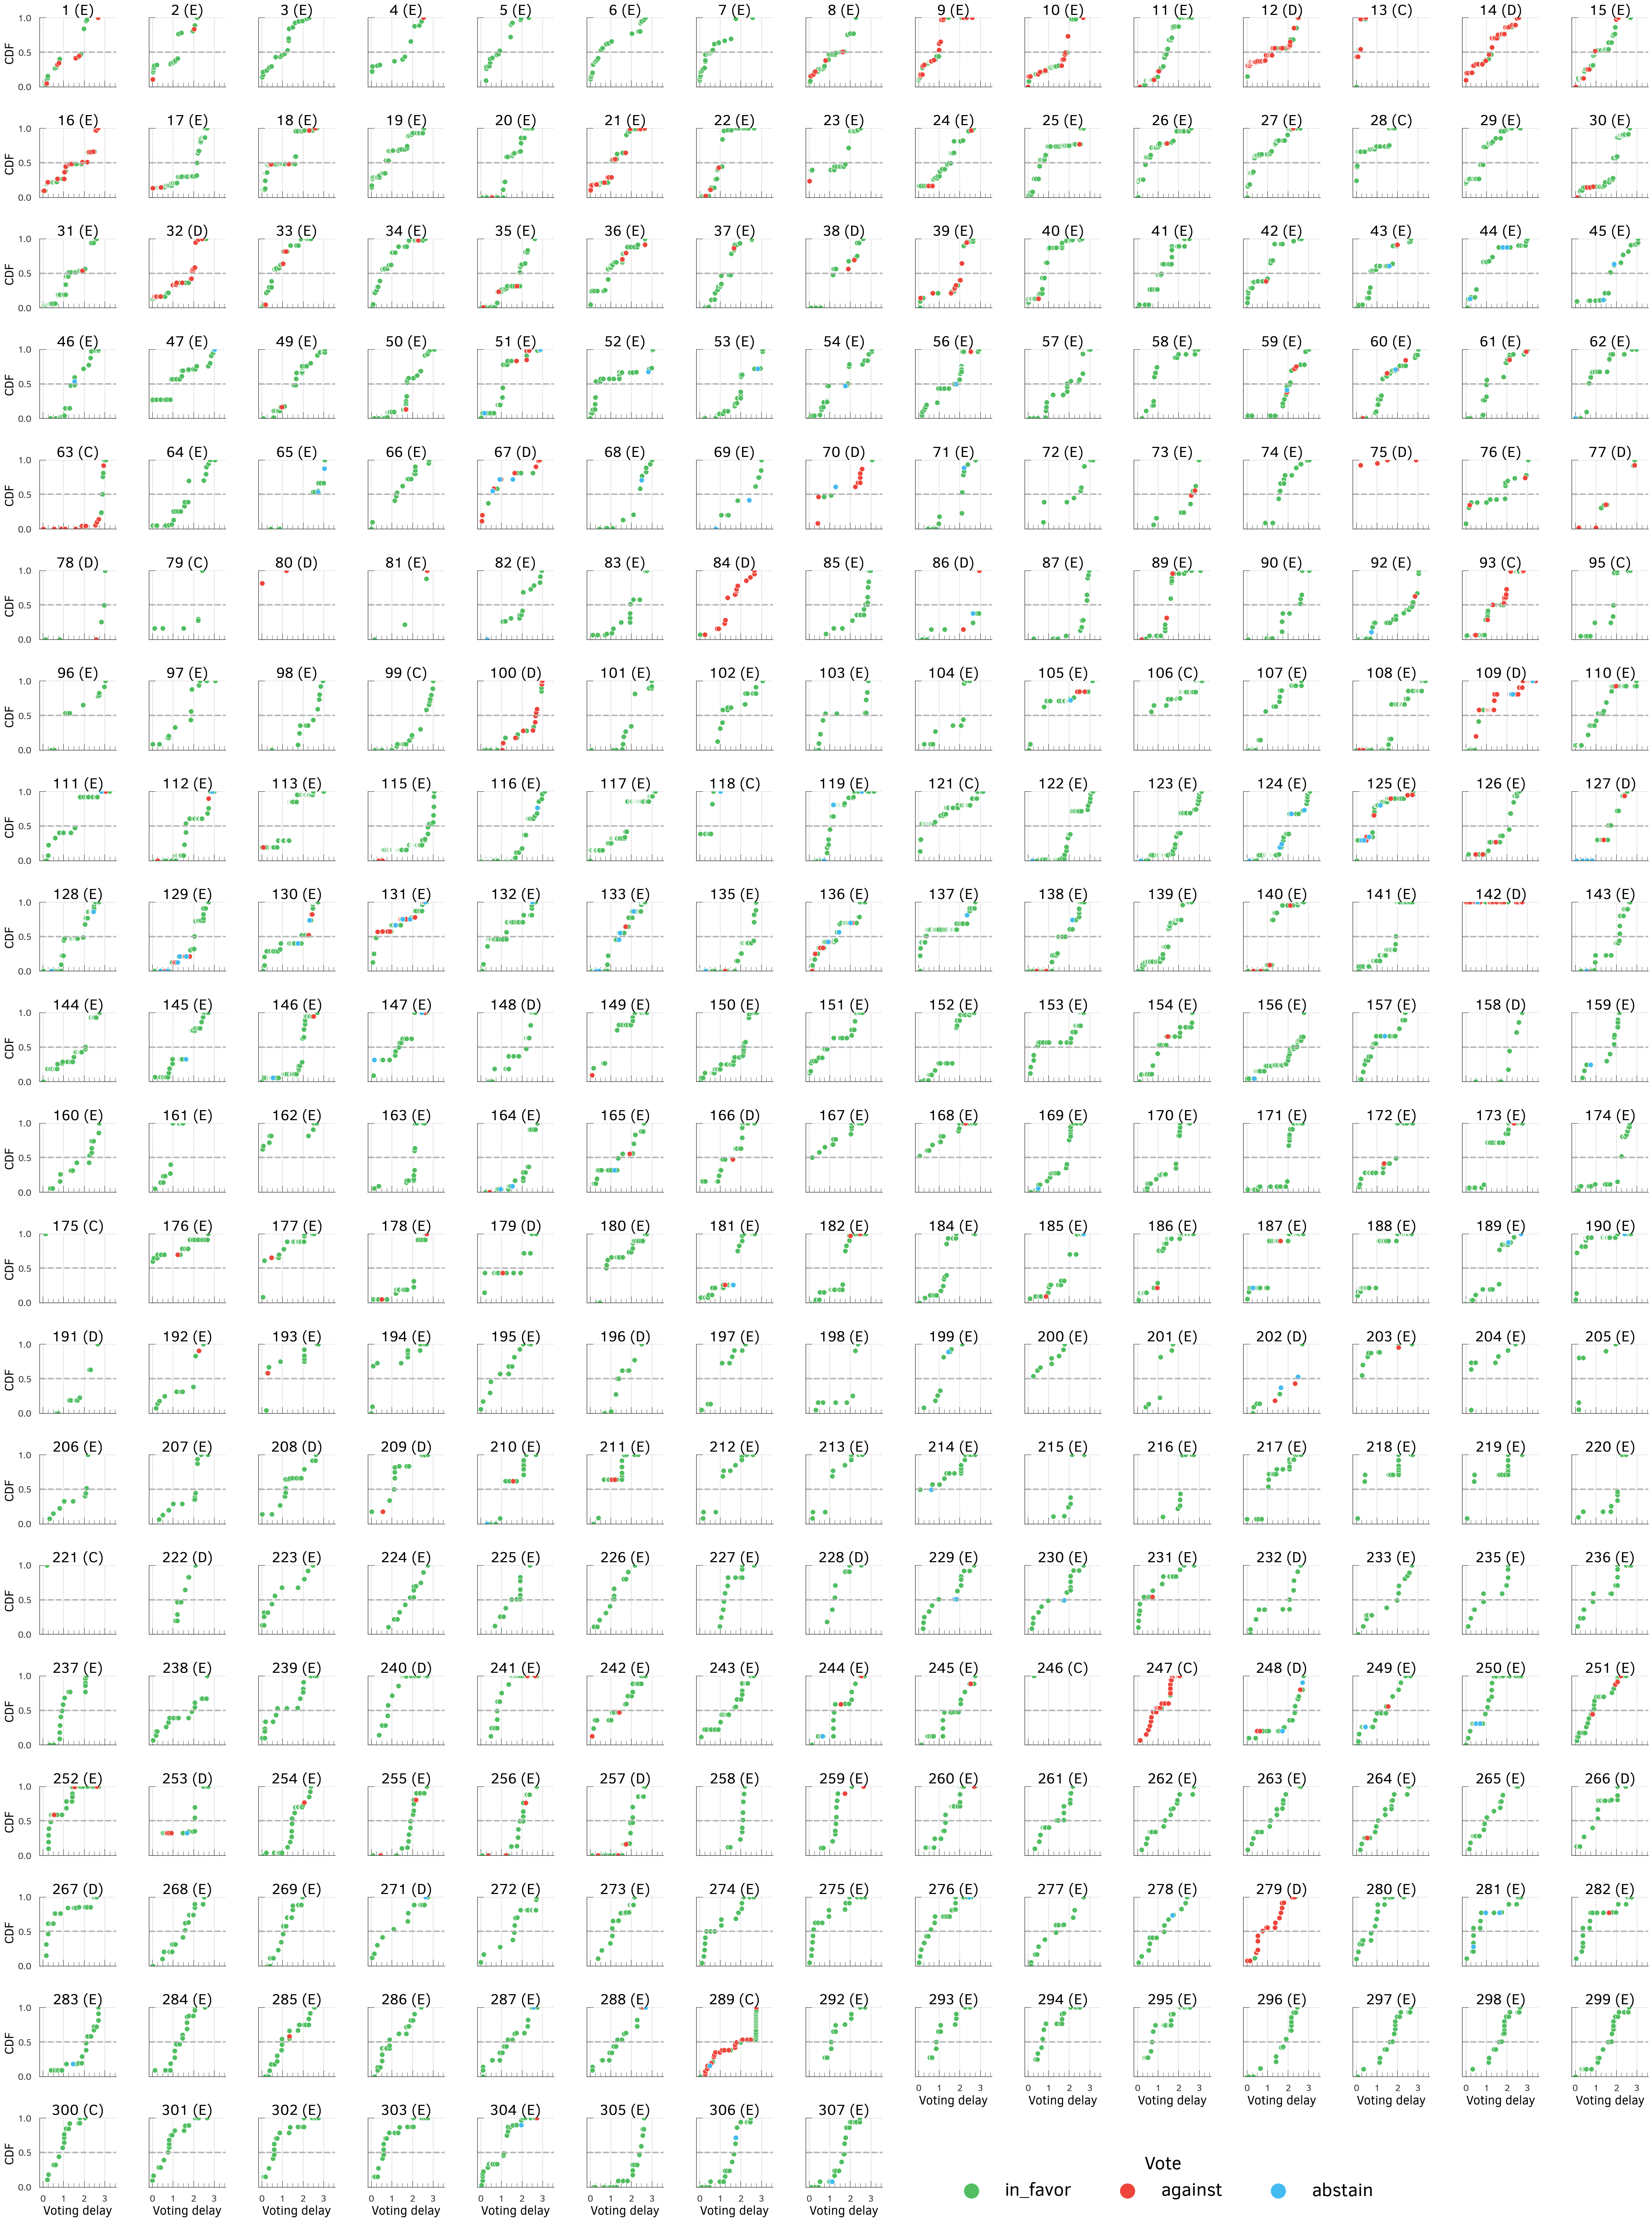

In [48]:
# Convert the timestamp to the minutes/hours it passed since the voting period began
display(voter_ts_df.head())

grid = sns.FacetGrid(voter_ts_df.rename(columns={'Votes fraction': 'CDF'}),
                     col="Proposal", col_wrap=15, hue='Voter', palette=dict(
                         in_favor=colors['green'], against=colors['red'], abstain=colors['blue']))

grid.map(sns.scatterplot, "Voting delay", "CDF", s=100)

grid.set(ylim=(0, 1))

for axes in grid.axes.flatten():
    axes.axhline(y=0.5, color=colors['grey'],
                 linestyle='--', linewidth=3, zorder=1)
    axes.set_xticks([0, 1, 2, 3])
    axes.set_xticks([0.25, 0.5, 0.75, 1.25, 1.5, 1.75,
                    2.25, 2.5, 2.75, 3.25, 3.5], minor=True)
    axes.tick_params(axis='x', which='both')
    proposal_id = int(axes.get_title().split('=')[-1].strip())
    axes.set_title(
        f'{proposal_id} ({proposal_status[proposal_id][0].upper()})')

grid.add_legend(title="Vote")

sns.move_legend(grid, "upper center", ncol=3,
                bbox_to_anchor=(.67, 0.04), fontsize=36, markerscale=3, title='Vote', title_fontsize=36)

file_dir = os.path.join(
    plots_dir, "voting_delay_day_per_proposal_{}.pdf".format(protocol_name))
plt.savefig(file_dir, bbox_inches='tight')

In [49]:
# Average voting delay per day
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

groupped_data = voter_ts_df.reset_index(drop=True).set_index(
    'Proposal').groupby(level='Proposal')
data = groupped_data['voting_delay'].mean().dt.total_seconds() / 3600 / 24
print("On average, it takes voters {} days to cast their votes.".format(
    data.mean().round(2)))
display(data.describe().to_frame().T)

data = data.to_frame().merge(proposals_created_timestamp_df[[
    'proposalId', 'proposal_created_timestamp']], left_on="Proposal", right_on="proposalId", how="left")
data.columns = ['voting_delay', 'proposalId', 'timestamp']
data = data.set_index('timestamp').sort_index()
data = data['voting_delay'].resample(
    'W').last().ffill().rolling(window=20).mean()

fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['blue'], width=4), mode='lines'))

fig.update_layout(
    yaxis_title="Voting delay (days)", xaxis_title="Date")

fig.update_xaxes(dtick="M4", tickformat="%b\n%Y",)

file_dir = os.path.join(
    plots_dir, "avg_vote_delay_per_day_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

On average, it takes voters 1.4 days to cast their votes.


count      mean       std       min       25%      50%  \
voting_delay  293.0  1.403862  0.384564  0.125972  1.169472  1.38275   

                   75%       max  
voting_delay  1.633484  2.811135

In [50]:
# Average voting delay per proposal
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

groupped_data = voter_ts_df.reset_index(drop=True).set_index(
    'Proposal').groupby(level='Proposal')
data = groupped_data['voting_delay'].mean().dt.total_seconds() / 3600 / 24
print("On average, it takes voters {} days to cast their votes.".format(
    data.mean().round(2)))
display(data.describe().to_frame().T)

data = data.to_frame().merge(proposals_created_timestamp_df[[
    'proposalId', 'proposal_created_timestamp']], left_on="Proposal", right_on="proposalId", how="left")
data.columns = ['voting_delay', 'proposalId', 'timestamp']
data = data.set_index('proposalId').sort_index()

fig.add_trace(go.Scatter(x=data.index, y=data['voting_delay'].rolling(window=10).mean(),
                         line=dict(
    color=colors['blue'], width=4), mode='lines'))

fig.update_layout(yaxis_title="Voting delay (days)", xaxis_title="Proposal ID",  xaxis=dict(tickmode='linear', tick0=0, dtick=40),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

file_dir = os.path.join(
    plots_dir, "avg_vote_delay_per_proposal_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

On average, it takes voters 1.4 days to cast their votes.


count      mean       std       min       25%      50%  \
voting_delay  293.0  1.403862  0.384564  0.125972  1.169472  1.38275   

                   75%       max  
voting_delay  1.633484  2.811135

### Quorum


In [51]:
# Number of voters that voted in favor of the proposal and the number of voters that voted against the proposal and reached the quorum
data = voter_ts_df.query('(Proposal in @proposal_executed_df.proposalId) and (Voter == "in_favor")').groupby(
    'Proposal').apply(lambda x: x.sort_values(by='votes', ascending=False)).reset_index(drop=True)
data['votes_cum'] = data.groupby(
    'Proposal')['votes'].cumsum()

data['ranking'] = data.groupby(
    'Proposal').votes_cum.rank(method='first', ascending=True).astype(int)

data = data.groupby('Proposal').apply(lambda x: x.query(
    'votes_cum >= @proposal_quorum')['ranking'].min())

display(data.describe().to_frame().T)

count      mean       std  min  25%  50%  75%   max
0  238.0  4.462185  2.518421  2.0  2.0  3.0  7.0  11.0

In [52]:
# It computes how long did it take for the proposal to reach quorum
quorum_df = votes_df.set_index('proposalId').groupby(level='proposalId').apply(lambda x: x.query('support == 1').sort_values(
    by=['blockNumber', 'transactionIndex', 'logIndex'],
    ascending=[True, True, True]).set_index('blockNumber').votes.cumsum().where(lambda x: x >= proposal_quorum).dropna().head(1)
).reset_index().rename(columns={'blockNumber': 'quorum_block_number'})

# It computes the time when the proposal was created
quorum_df = quorum_df.merge(proposal_created_df[['startBlock', 'proposalId']].rename(
    columns={'startBlock': 'blockNumber_start'}), on='proposalId', how='left').dropna()

# It computes the time when the proposal reached quorum
quorum_df = quorum_df.merge(blocks_df, left_on='quorum_block_number', right_on='number',
                            how='left').rename(columns={'timestamp': 'quorum_timestamp'})

quorum_df = quorum_df.merge(
    votes_weighted_df[['proposalId', 'status']], on='proposalId', how='left')

# It computes the time when the proposal was created
quorum_df = quorum_df.merge(blocks_df, left_on='blockNumber_start', right_on='number',
                            how='left').rename(columns={'timestamp': 'proposal_created_timestamp'})
quorum_df.drop(columns=['votes', 'number_x', 'number_y'], inplace=True)
quorum_df['time_to_quorum'] = (quorum_df['quorum_timestamp'] -
                               quorum_df['proposal_created_timestamp']).dt.total_seconds()/3600/24
quorum_df['block_to_quorum'] = quorum_df['quorum_block_number'] - \
    quorum_df['blockNumber_start']
quorum_df.head()

proposalId  quorum_block_number  blockNumber_start    quorum_timestamp  \
0           1              9964730            9951905 2020-04-29 02:26:04   
1           2              9964727            9956585 2020-04-29 02:25:30   
2           3             10073762           10065393 2020-05-15 23:54:15   
3           4             10132059           10117039 2020-05-25 01:36:44   
4           5             10188574           10179119 2020-06-02 20:24:39   

     status proposal_created_timestamp  time_to_quorum  block_to_quorum  
0  executed        2020-04-27 02:42:00        1.988935            12825  
1  executed        2020-04-27 20:09:08        1.261366             8142  
2  executed        2020-05-14 16:34:47        1.305185             8369  
3  executed        2020-05-22 17:44:18        2.328079            15020  
4  executed        2020-06-01 09:13:55        1.465787             9455

In [53]:
maker_colors = {'executed': colors['green'],
                'defeated': colors['red'], 'canceled': colors['blue']}

markers = {'executed': 'circle', 'defeated': 'x', 'canceled': 'diamond-tall'}

data = quorum_df.set_index('proposal_created_timestamp').time_to_quorum

fig = go.Figure(layout=get_plotly_layout(width=1540, height=350))
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['grey'], width=2), mode='lines', name='# days', marker_size=5))

data = data.resample('ME').mean()

fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['blue'], width=4), mode='lines', name='Monthly average', marker_size=10))


for status in ['executed', 'defeated', 'canceled']:
    data = quorum_df.query('(status == @status)').reset_index(drop=True)
    data['text'] = "Proposal #" + data['proposalId'].astype(str)
    fig.add_trace(go.Scatter(x=quorum_df.query('status==@status')['proposal_created_timestamp'],
                             y=[-0.04]*len(quorum_df),
                             mode='markers', name=status.capitalize(),
                             marker=dict(
        color=maker_colors[status], size=15, opacity=0.7, symbol=markers[status], line=dict(width=1, color='white')
    ), text=data['text']))

fig.update_layout(
    xaxis_title='Proposal creation time',
    yaxis_title='Days to reach quorum',
    legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'),
    yaxis=dict(tickmode='linear', tick0=0, dtick=1)
)
fig.update_xaxes(dtick="M2", tickformat="%b\n%Y",
                 range=[quorum_df.proposal_created_timestamp.min()-pd.Timedelta('3W'),
                        quorum_df.proposal_created_timestamp.max()+pd.Timedelta('3W')])
fig.update_yaxes(range=[-0.2, 3.1])

file_dir = os.path.join(
    plots_dir, "time_to_quorum_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=1540, height=350, scale=1)

fig.show(plot_style)

In [54]:
data = quorum_df.set_index(
    'proposal_created_timestamp').time_to_quorum.describe()
print("On average, it takes {} days for a proposal to reach quorum.".format(
    data['mean'].round(2)))
data.to_frame().T

On average, it takes 1.69 days for a proposal to reach quorum.


count      mean      std       min       25%       50%  \
time_to_quorum  252.0  1.689402  0.68788  0.086528  1.120903  1.808588   

                     75%      max  
time_to_quorum  2.146007  3.01735

### Voting Cost


In [55]:
from plot_utils import plot_ohlc

In [56]:
file_dir = os.path.join(data_dir + "transactions_of_votes.csv.gz")
votes_transactions_df = pd.read_csv(file_dir)
votes_transactions_df['timestamp'] = pd.to_datetime(
    votes_transactions_df['timestamp'])
votes_transactions_df.head()

tx_hash  tx_block_number  \
0  43cf2f48d2d77816123fb95bc8aa7394cd6d06b7ee219f...         15703859   
1  c8b44a55e5d9a2593bc110b63362c3d84e5a1fee041575...         17996706   
2  9dfeb0296e685b3a15fa407715583732045bb9a81e6e3d...         19507380   
3  dad8a397ed3725c5ae2febd0f9f128c6ab01f17435718a...         10226261   
4  f69da2f52f4e3b6f2797ac40a9d1edf21d0ef9802cbd4d...         13225977   

   tx_effective_gas_price  tx_gas_used  tx_fee_eth           timestamp  
0              7546215611        79856    0.000603 2022-10-08 14:05:59  
1             12168780679        79856    0.000972 2023-08-26 05:16:47  
2             17965880351        79984    0.001437 2024-03-24 22:32:23  
3             30500000000        63134    0.001926 2020-06-08 16:45:48  
4             68000000000        80554    0.005478 2021-09-14 20:23:28

In [57]:
file_fir = os.path.join(data_dir, "yahoo_price_eth_usd.csv")
yahoo_price_df = pd.read_csv(file_fir)
yahoo_price_df.columns = [column.lower() for column in yahoo_price_df.columns]
yahoo_price_df['date'] = pd.to_datetime(yahoo_price_df['date'])
yahoo_price_df.head()

date        open        high         low       close   adj close  \
0 2017-11-09  308.644989  329.451996  307.056000  320.884003  320.884003   
1 2017-11-10  320.670990  324.717987  294.541992  299.252991  299.252991   
2 2017-11-11  298.585999  319.453003  298.191986  314.681000  314.681000   
3 2017-11-12  314.690002  319.153015  298.513000  307.907990  307.907990   
4 2017-11-13  307.024994  328.415009  307.024994  316.716003  316.716003   

       volume  
0   893249984  
1   885985984  
2   842300992  
3  1613479936  
4  1041889984

In [58]:
data = yahoo_price_df.set_index('date')['2020-06-01':]

fig = plot_ohlc(data[['open', 'high', 'low', 'close']])
sma = data['close'].rolling(min_periods=1, window=1,
                            center=False).mean().resample('10D').last()
fig.update_layout(
    get_plotly_layout(width=width, height=height),
    showlegend=True,
    legend=dict(xanchor='center', x=0.9, y=.95, orientation='h')
)
fig.add_trace(go.Scatter(x=sma.index, y=sma, mode='lines',
              name='Price', line=dict(color=colors['blue'], width=4)))

fig.update_xaxes(dtick="M4", tickformat="%b\n%Y",)

file_dir = os.path.join(plots_dir, "yahoo_price_eth_usd.pdf")
fig.write_image(file_dir, width=width, height=height)
fig.show(plot_style)

In [59]:
votes_cost_df = votes_df[['blockNumber', 'transactionHash', 'transactionIndex',
                          'logIndex', 'proposalId', 'votes', 'voter']]
votes_cost_df = votes_cost_df.merge(votes_transactions_df[['tx_hash', 'timestamp', 'tx_effective_gas_price', 'tx_gas_used',
                                    'tx_fee_eth']], left_on='transactionHash', right_on='tx_hash', how='left').drop(columns=['tx_hash'])
votes_cost_df['timestamp'] = pd.to_datetime(
    votes_cost_df['timestamp'].dt.strftime('%Y-%m-%d'))
votes_cost_df = votes_cost_df.merge(yahoo_price_df[['date', 'close']].rename(columns={
                                    'close': 'price_usd'}), left_on='timestamp', right_on='date', how='left').drop(columns=['date'])
votes_cost_df['tx_fee_usd'] = votes_cost_df['tx_fee_eth'] * \
    votes_cost_df['price_usd']
votes_cost_df['cost_normalized_per_vote'] = votes_cost_df['tx_fee_usd'] / \
    votes_cost_df['votes']
votes_cost_df.head()

blockNumber                                    transactionHash  \
0      9952490  07076f7d6247f9c5c4703085b8adf30510bf1f96bdc9ba...   
1      9952737  70851da3c89a8c1b30833e57bd52225f0752432dcef84d...   
2      9952767  1d0f2246f485d7862a7b5f97ba19059c69733c7642b4dd...   
3      9953038  c8b158cbab11e1ca226bf6ee8a8eeb8337c1771a5f67a3...   
4      9953051  40ad76ab86471ac45a690a2f7cec7be9025940e47699ff...   

   transactionIndex  logIndex  proposalId     votes  \
0                44        35           1  24107.64   
1                99        80           1      1.00   
2                93       126           1   5000.00   
3               112       152           1  12500.00   
4               135       156           1  50000.00   

                                        voter  timestamp  \
0  0xb0325dbe7fa891436e83a094f9f12848c78e449b 2020-04-27   
1  0x181fc4a2b228c0e0f996b736f0310cf9b2e34b56 2020-04-27   
2  0xe3c9ece23316b6b06142fa0ca915f02c323c6b21 2020-04-27   
3  0x8703028934b24b47496ad84afd635ea7938487be 2020-04-27   
4  0x1d29756e8f7b091ce6c11a35980de79c7eda5d1f 2020-04-27   

   tx_effective_gas_price  tx_gas_used  tx_fee_eth   price_usd  tx_fee_usd  \
0              6750000000        78134    0.000527  197.224716    0.104017   
1              9000000000        63134    0.000568  197.224716    0.112064   
2              3388000256        63134    0.000214  197.224716    0.042186   
3              5750000000        78112    0.000449  197.224716    0.088582   
4              8000000000        63134    0.000505  197.224716    0.099613   

   cost_normalized_per_vote  
0                  0.000004  
1                  0.112064  
2                  0.000008  
3                  0.000007  
4                  0.000002

In [60]:
# Voting cost per proposal
fig = go.Figure(layout=get_plotly_layout(width=1540, height=350))

display(votes_cost_df.tx_fee_usd.describe().to_frame().T)
print("All proposals cost a total of ${} in fees.".format(
    votes_cost_df.tx_fee_usd.sum().round(2)))

data = votes_cost_df.groupby('proposalId').tx_fee_usd.sum()
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['light_purple'], width=4), mode='lines', name='total cost'))

data = votes_cost_df.groupby('proposalId').tx_fee_usd.median()
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['brown'], width=2), mode='lines', name='median cost'))

data = votes_cost_df.query(
    'proposalId not in @proposals_defeated_df.proposalId')
fig.add_trace(go.Box(x=data.proposalId, y=data.tx_fee_usd,
              name='Executed', marker_color=colors['green'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = votes_cost_df.query(
    'proposalId in @proposals_defeated_df.proposalId')
fig.add_trace(go.Box(x=data.proposalId, y=data.tx_fee_usd,
              name='Defeated', marker_color=colors['red'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = votes_cost_df.query(
    'proposalId in @proposal_cancelled_df.proposalId')
fig.add_trace(go.Box(x=data.proposalId, y=data.tx_fee_usd,
              name='Canceled', marker_color=colors['blue'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

fig.update_layout(yaxis_title="Voting cost (in USD)", xaxis_title="Proposal ID", xaxis=dict(tickmode='linear', tick0=0, dtick=10),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

fig.update_yaxes(type='log')

file_dir = os.path.join(
    plots_dir, "voting_cost_per_proposal_boxplot_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=1540, height=380, scale=1)
fig.show(plot_style)

count      mean        std       min       25%       50%  \
tx_fee_usd  14841.0  6.815866  19.042343  0.025054  0.881285  1.665471   

                75%         max  
tx_fee_usd  4.43664  294.015473

All proposals cost a total of $101154.27 in fees.


In [61]:
# Voting cost per proposal

# maker_colors = {'executed': colors['green'],
#                 'defeated': colors['red'], 'canceled': colors['blue']}

# markers = {'executed': 'circle', 'defeated': 'x', 'canceled': 'diamond-tall'}


# Voting cost per proposal
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))


display(votes_cost_df.tx_fee_usd.describe().to_frame().T)
print("All proposals cost a total of ${} in fees.".format(
    votes_cost_df.tx_fee_usd.sum().round(2)))

data = votes_cost_df.groupby('proposalId').tx_fee_usd.sum()
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['light_purple'], width=4), mode='lines', name='total cost'))

data = votes_cost_df.groupby('proposalId').tx_fee_usd.median()
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['brown'], width=2), mode='lines', name='median cost'))

# for status in ['executed', 'defeated', 'canceled']:
#     data = proposals_created_timestamp_df.query(
#         'status == @status').reset_index()
#     data['text'] = "Proposal #" + data['proposalId'].astype(str)
#     fig.add_trace(go.Scatter(x=proposals_created_timestamp_df.query('status==@status')['proposalId'],
#                              y=[0.1]*len(proposals_created_timestamp_df),
#                              mode='markers', name=status.capitalize(),
#                              marker=dict(
#         color=maker_colors[status], size=15, opacity=0.7, symbol=markers[status], line=dict(width=1, color='white')
#     ), text=data['text']))

fig.update_layout(yaxis_title="Voting cost (in USD)", xaxis_title="Proposal ID", xaxis=dict(tickmode='linear', tick0=0, dtick=20, range=[0, proposal_created_df.proposalId.max()]),
                  yaxis=dict(tickmode='linear', tick0=0, dtick=1),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

fig.update_yaxes(type='log')

file_dir = os.path.join(
    plots_dir, "voting_cost_per_proposal_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

count      mean        std       min       25%       50%  \
tx_fee_usd  14841.0  6.815866  19.042343  0.025054  0.881285  1.665471   

                75%         max  
tx_fee_usd  4.43664  294.015473

All proposals cost a total of $101154.27 in fees.


In [62]:
# Distribution of the voting cost per proposal
votes_cost_df.groupby('proposalId').tx_fee_usd.sum().describe().to_frame().T

count      mean         std       min        25%         50%  \
tx_fee_usd  293.0  345.2364  543.231257  1.222473  75.985752  167.521971   

                   75%         max  
tx_fee_usd  330.936633  4247.25447

In [63]:
# Normalized voting cost per proposal

min_votes = 1e-6

fig = go.Figure(layout=get_plotly_layout(width=1540, height=350))

data = votes_cost_df.query(
    '(proposalId not in @proposals_defeated_df.proposalId) and (votes >= @min_votes)')
fig.add_trace(go.Box(x=data.proposalId, y=data.cost_normalized_per_vote,
              name='Executed', marker_color=colors['green'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = votes_cost_df.query(
    '(proposalId in @proposals_defeated_df.proposalId) and (votes >= @min_votes)')
fig.add_trace(go.Box(x=data.proposalId, y=data.cost_normalized_per_vote,
              name='Defeated', marker_color=colors['red'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = votes_cost_df.query(
    '(proposalId in @proposal_cancelled_df.proposalId) and (votes >= @min_votes)')
fig.add_trace(go.Box(x=data.proposalId, y=data.cost_normalized_per_vote,
              name='Canceled', marker_color=colors['blue'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

fig.update_layout(yaxis_title="Cost per vote unit (USD)", xaxis_title="Proposal ID", xaxis=dict(tickmode='linear', tick0=0, dtick=10),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

fig.update_yaxes(type='log')

file_dir = os.path.join(
    plots_dir, "voting_cost_per_proposal_normalized_{}.pdf".format(protocol_name))

fig.write_image(file_dir, width=1540, height=380, scale=1)
fig.show(plot_style)

In [64]:
# Distribution of the normalized voting cost per proposal
data['cost_normalized_per_vote'].describe().to_frame().T

count       mean          std       min       25%  \
cost_normalized_per_vote  584.0  598.97225  7739.339094  0.000004  0.002067   

                               50%        75%            max  
cost_normalized_per_vote  6.382188  43.723012  138170.575268

### Vote Similarity


In [179]:
# Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [180]:
from plot_utils import plot_heatmap_votes, plot_heatmap

In [181]:
voter_df = votes_df[['proposalId', 'voter', 'support']].reset_index(drop=True)
voter_df['voter_label'] = voter_df['voter'].apply(
    lambda x: labels.get(x, x[:6]+"..."+x[-4:]))
voter_df.head()

proposalId                                       voter  support  \
0           1  0xb0325dbe7fa891436e83a094f9f12848c78e449b        1   
1           1  0x181fc4a2b228c0e0f996b736f0310cf9b2e34b56        1   
2           1  0xe3c9ece23316b6b06142fa0ca915f02c323c6b21        1   
3           1  0x8703028934b24b47496ad84afd635ea7938487be        0   
4           1  0x1d29756e8f7b091ce6c11a35980de79c7eda5d1f        1   

     voter_label  
0     Calvin Liu  
1  0x181f...4b56  
2        dakeshi  
3          Jacob  
4      InstaDApp

In [182]:
# Voters who votred on more proposals
voter_df['voter_label'].value_counts().head()

voter_label
Michigan Blockchain    192
Franklin DAO           184
MonetSupply            167
allthecolors           163
Gauntlet               154
Name: count, dtype: int64

In [183]:
n_votes = 15
top_voters = voter_df['voter_label'].value_counts()
top_voters = top_voters[top_voters >= n_votes].index
print("There are {} ({}%) out of {} voters with at least {} votes".format(len(top_voters),
      round(100*len(top_voters)/voter_df['voter_label'].nunique(), 2), voter_df.voter.nunique(), n_votes))

There are 91 (2.01%) out of 4538 voters with at least 15 votes


In [184]:
votes_vector = voter_df.query('voter_label in @top_voters')[['proposalId', 'support', 'voter_label']].pivot_table(
    index='voter_label', columns='proposalId', values='support').loc[top_voters]

missing_proposals = set(votes_weighted_df.proposalId) - \
    set(votes_vector.columns)
print("There are {} missing proposals".format(len(missing_proposals)))
print(sorted(missing_proposals))
for proposalId in missing_proposals:
    votes_vector[proposalId] = np.nan
votes_vector = votes_vector[votes_weighted_df.proposalId]

There are 15 missing proposals
[48, 55, 88, 91, 94, 114, 120, 134, 155, 175, 183, 234, 270, 290, 291]


In [185]:
# Plot how each of the top 15 voters (based on # of proposals voted) voted on each proposal
fig = plot_heatmap_votes(
    df=votes_vector.head(15), xgap=1, ygap=1)

fig.update_layout(yaxis=dict(tickfont=dict(size=12.9)))

file_dir = os.path.join(
    plots_dir, "heatmap_votes_top_voters_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

In [186]:
proposal_ids = sorted(set(votes_vector.columns) - set(missing_proposals))
data = votes_vector[proposal_ids]+1
cosine_df = pd.DataFrame(cosine_similarity(
    data.fillna(0)), index=data.index, columns=data.index)
cosine_df.head()

voter_label          Michigan Blockchain  Franklin DAO  MonetSupply  \
voter_label                                                           
Michigan Blockchain             1.000000      0.797800     0.575877   
Franklin DAO                    0.797800      1.000000     0.574429   
MonetSupply                     0.575877      0.574429     1.000000   
allthecolors                    0.751320      0.705317     0.558775   
Gauntlet                        0.535362      0.573307     0.576726   

voter_label          allthecolors  Gauntlet  Wintermute   dakeshi  Avantgarde  \
voter_label                                                                     
Michigan Blockchain      0.751320  0.535362    0.794114  0.483675    0.775304   
Franklin DAO             0.705317  0.573307    0.713379  0.461425    0.691048   
MonetSupply              0.558775  0.576726    0.380390  0.602404    0.449201   
allthecolors             1.000000  0.504555    0.666877  0.450450    0.642556   
Gauntlet                 0.504555  1.000000    0.436525  0.493235    0.446109   

voter_label              PGov  0x84e3...5a95  ...  0xd4ad...ed1c  \
voter_label                                   ...                  
Michigan Blockchain  0.750929       0.401957  ...       0.076612   
Franklin DAO         0.681383       0.427493  ...       0.039285   
MonetSupply          0.353475       0.659320  ...       0.288859   
allthecolors         0.619021       0.416966  ...       0.000000   
Gauntlet             0.433906       0.504058  ...       0.276909   

voter_label          0xa772...6171  Kain | Synthetix  0xf15a...66bb  GFX Labs  \
voter_label                                                                     
Michigan Blockchain       0.268320          0.000000       0.228281  0.162265   
Franklin DAO              0.257422          0.000000       0.216104  0.196666   
MonetSupply               0.167836          0.176777       0.293211  0.248960   
allthecolors              0.188088          0.000000       0.276652  0.133564   
Gauntlet                  0.115513          0.233193       0.175762  0.098433   

voter_label          IDEO CoLab Ventures  0x4afa...7426  0xab7b...fb26  \
voter_label                                                              
Michigan Blockchain             0.000000       0.270634       0.193203   
Franklin DAO                    0.000000       0.235654       0.262534   
MonetSupply                     0.121232       0.033005       0.234146   
allthecolors                    0.000000       0.205280       0.188928   
Gauntlet                        0.206508       0.164688       0.161151   

voter_label          0xa0e4...ea1e  onesol.eth  
voter_label                                     
Michigan Blockchain       0.019320    0.225973  
Franklin DAO              0.000000    0.212434  
MonetSupply               0.270569    0.202860  
allthecolors              0.000000    0.235295  
Gauntlet                  0.214868    0.209427  

[5 rows x 91 columns]

In [187]:
fig = plot_heatmap(
    cosine_df.head(15),
    freq_text="Cosine similarity",  font_size_z=12, annotation=True)

fig.update_layout(yaxis=dict(tickfont=dict(size=12)))
fig.update_traces(showscale=False)

file_dir = os.path.join(
    plots_dir, "cosine_similarity_top_voters_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=1540, height=380, scale=1)
fig.show(plot_style)

In [188]:
data_votes = voter_df.query('voter_label in @top_voters')[['proposalId', 'support', 'voter_label']].pivot_table(
    index='voter_label', columns='proposalId', values='support').loc[top_voters]
data_votes = data_votes.clip(0, 1).fillna(0)
data_votes.head()

proposalId           1    2    3    4    5    6    7    8    9    10   ...  \
voter_label                                                            ...   
Michigan Blockchain  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
Franklin DAO         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
MonetSupply          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
allthecolors         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
Gauntlet             1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  ...   

proposalId           298  299  300  301  302  303  304  305  306  307  
voter_label                                                            
Michigan Blockchain  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Franklin DAO         1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  
MonetSupply          1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  
allthecolors         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Gauntlet             0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  

[5 rows x 292 columns]

In [189]:
cosine_df = pd.DataFrame(cosine_similarity(
    data_votes), index=data_votes.index, columns=data_votes.index)
cosine_df.head()

voter_label          Michigan Blockchain  Franklin DAO  MonetSupply  \
voter_label                                                           
Michigan Blockchain             1.000000      0.795774     0.569162   
Franklin DAO                    0.795774      1.000000     0.575884   
MonetSupply                     0.569162      0.575884     1.000000   
allthecolors                    0.754870      0.698820     0.567789   
Gauntlet                        0.537865      0.568421     0.577301   

voter_label          allthecolors  Gauntlet  Wintermute   dakeshi  Avantgarde  \
voter_label                                                                     
Michigan Blockchain      0.754870  0.537865    0.796483  0.460317    0.773791   
Franklin DAO             0.698820  0.568421    0.714064  0.450436    0.692199   
MonetSupply              0.567789  0.577301    0.385742  0.585341    0.454980   
allthecolors             1.000000  0.505053    0.673710  0.441092    0.645244   
Gauntlet                 0.505053  1.000000    0.438397  0.477890    0.446981   

voter_label              PGov  0x84e3...5a95  ...  0xd4ad...ed1c  \
voter_label                                   ...                  
Michigan Blockchain  0.752676       0.389271  ...       0.078598   
Franklin DAO         0.681748       0.425417  ...       0.040177   
MonetSupply          0.358352       0.648410  ...       0.277287   
allthecolors         0.624370       0.405907  ...       0.000000   
Gauntlet             0.435522       0.502751  ...       0.263625   

voter_label          0xa772...6171  Kain | Synthetix  0xf15a...66bb  GFX Labs  \
voter_label                                                                     
Michigan Blockchain       0.265764          0.000000       0.238945  0.142738   
Franklin DAO              0.252296          0.000000       0.225494  0.187622   
MonetSupply               0.164852          0.159617       0.299283  0.221349   
allthecolors              0.187867          0.000000       0.282958  0.112112   
Gauntlet                  0.127343          0.205499       0.184949  0.091192   

voter_label          IDEO CoLab Ventures  0x4afa...7426  0xab7b...fb26  \
voter_label                                                              
Michigan Blockchain             0.000000       0.254686       0.196494   
Franklin DAO                    0.000000       0.216982       0.261152   
MonetSupply                     0.106412       0.023039       0.234627   
allthecolors                    0.000000       0.186704       0.194461   
Gauntlet                        0.191799       0.142374       0.153781   

voter_label          0xa0e4...ea1e  onesol.eth  
voter_label                                     
Michigan Blockchain       0.019649    0.227798  
Franklin DAO              0.000000    0.213482  
MonetSupply               0.255957    0.206065  
allthecolors              0.000000    0.229616  
Gauntlet                  0.219687    0.212238  

[5 rows x 91 columns]

In [190]:
colorscale = [
    [0.0, colors['white']], [0.5, colors['white']],
    [0.5, colors['blue']], [1.0, colors['blue']]
]

fig = plot_heatmap_votes(df=data_votes.head(15), ticktext=['Non-vote', 'Voted'],
                         zmax=0, tickvals=[0, 1], colorscale=colorscale,  colorbarlen=100)

fig.update_layout(yaxis=dict(tickfont=dict(size=12)))

In [191]:
proposal_ids = sorted(set(votes_vector.columns) - set(missing_proposals))
data = votes_vector[proposal_ids]+1
cosine_df = pd.DataFrame(cosine_similarity(
    data.fillna(0)), index=data.index, columns=data.index)
cosine_df.head()

voter_label          Michigan Blockchain  Franklin DAO  MonetSupply  \
voter_label                                                           
Michigan Blockchain             1.000000      0.797800     0.575877   
Franklin DAO                    0.797800      1.000000     0.574429   
MonetSupply                     0.575877      0.574429     1.000000   
allthecolors                    0.751320      0.705317     0.558775   
Gauntlet                        0.535362      0.573307     0.576726   

voter_label          allthecolors  Gauntlet  Wintermute   dakeshi  Avantgarde  \
voter_label                                                                     
Michigan Blockchain      0.751320  0.535362    0.794114  0.483675    0.775304   
Franklin DAO             0.705317  0.573307    0.713379  0.461425    0.691048   
MonetSupply              0.558775  0.576726    0.380390  0.602404    0.449201   
allthecolors             1.000000  0.504555    0.666877  0.450450    0.642556   
Gauntlet                 0.504555  1.000000    0.436525  0.493235    0.446109   

voter_label              PGov  0x84e3...5a95  ...  0xd4ad...ed1c  \
voter_label                                   ...                  
Michigan Blockchain  0.750929       0.401957  ...       0.076612   
Franklin DAO         0.681383       0.427493  ...       0.039285   
MonetSupply          0.353475       0.659320  ...       0.288859   
allthecolors         0.619021       0.416966  ...       0.000000   
Gauntlet             0.433906       0.504058  ...       0.276909   

voter_label          0xa772...6171  Kain | Synthetix  0xf15a...66bb  GFX Labs  \
voter_label                                                                     
Michigan Blockchain       0.268320          0.000000       0.228281  0.162265   
Franklin DAO              0.257422          0.000000       0.216104  0.196666   
MonetSupply               0.167836          0.176777       0.293211  0.248960   
allthecolors              0.188088          0.000000       0.276652  0.133564   
Gauntlet                  0.115513          0.233193       0.175762  0.098433   

voter_label          IDEO CoLab Ventures  0x4afa...7426  0xab7b...fb26  \
voter_label                                                              
Michigan Blockchain             0.000000       0.270634       0.193203   
Franklin DAO                    0.000000       0.235654       0.262534   
MonetSupply                     0.121232       0.033005       0.234146   
allthecolors                    0.000000       0.205280       0.188928   
Gauntlet                        0.206508       0.164688       0.161151   

voter_label          0xa0e4...ea1e  onesol.eth  
voter_label                                     
Michigan Blockchain       0.019320    0.225973  
Franklin DAO              0.000000    0.212434  
MonetSupply               0.270569    0.202860  
allthecolors              0.000000    0.235295  
Gauntlet                  0.214868    0.209427  

[5 rows x 91 columns]

## Extra


In [192]:
# rows = voters, columns = proposals, values = -1 (no), 0 (abstain), 1 (yes)
votes_vector_copy = votes_vector.replace(
    {2: 'abstain', 1: 'in-favor', 0: 'against'})
votes_vector_copy = votes_vector.replace(
    {'against': -1, 'abstain': 0, 'in-favor': 1})
votes_vector_copy.head()

proposalId           1    2    3    4    5    6    7    8    9    10   ...  \
voter_label                                                            ...   
Michigan Blockchain  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
Franklin DAO         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
MonetSupply          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
allthecolors         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
Gauntlet             1.0  NaN  NaN  1.0  1.0  1.0  1.0  1.0  0.0  0.0  ...   

proposalId           298  299  300  301  302  303  304  305  306  307  
voter_label                                                            
Michigan Blockchain  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Franklin DAO         1.0  1.0  1.0  1.0  NaN  NaN  1.0  1.0  1.0  1.0  
MonetSupply          1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  NaN  NaN  
allthecolors         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Gauntlet             NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  

[5 rows x 307 columns]

In [193]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

cosine_threshold = 0.7

# Replace abstain (0) with np.nan so they don’t affect cosine similarity
vote_df_nan = votes_vector_copy.replace(0, np.nan)

# Fill NaNs with 0 for cosine similarity (or keep them as 0 if 0 means abstain)
cos_sim = cosine_similarity(vote_df_nan.fillna(0)).round(4)

# Create graph
G = nx.Graph()
for i, voter_i in enumerate(vote_df_nan.index):
    # G.add_node(voter_i)
    for j, voter_j in enumerate(vote_df_nan.index):
        if i < j:
            sim_score = cos_sim[i][j]
            if sim_score > cosine_threshold:  # Only keep strong similarities
                G.add_edge(voter_i, voter_j, weight=sim_score)

components = sorted(nx.connected_components(
    G.to_undirected()), key=len, reverse=True)
print("Number of components:", len(components))

component_id = 1
for component in components:
    for node in component:
        G.nodes[node]['component'] = component_id
        G.nodes[node]['component_length'] = len(component)
        G.nodes[node]['degree'] = G.degree(node)
    component_id += 1

print(G.number_of_nodes(), G.number_of_edges())
filepath = os.path.realpath(os.path.join(data_dir, "graph_similarity_compound.gexf"))
nx.write_gexf(G, filepath)

Number of components: 6
24 25


In [194]:
len(components[0])

13

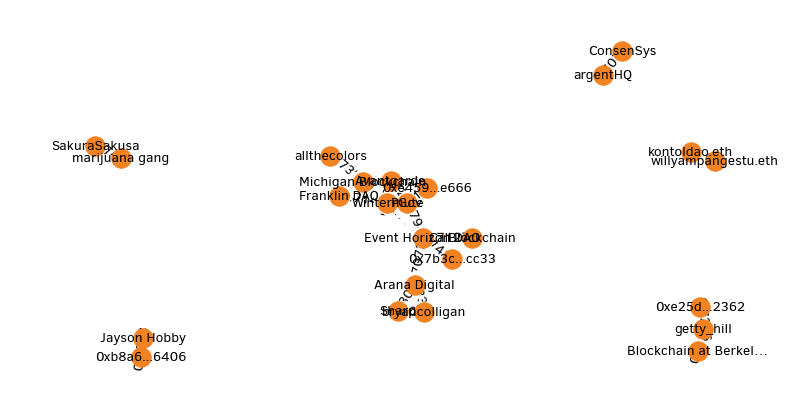

In [195]:
## Add a different color for each of the sub-graphs.

import matplotlib.pyplot as plt
import networkx as nx


edge_list = G.edges(data=True)

# positions for all nodes - seed for reproducibility
pos = nx.spring_layout(G, scale=4.0)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=colors['orange'])

# edges
nx.draw_networkx_edges(
    G, pos, edgelist=edge_list, width=3, alpha=0.5, edge_color=colors['purple'], style="solid"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

### Vote alignment: How many times the most frequently voters were right on their decision?


In [196]:
outcome_series = pd.Series(proposal_status).map(
    {"executed": True, "defeated": False}).dropna().astype(bool)

In [197]:
data_votes = voter_df.query("voter_label in @top_voters and support != 2")[['proposalId', 'support', 'voter_label']].pivot_table(
    index='voter_label', columns='proposalId', values='support').loc[top_voters]
data_votes.head()

proposalId           1    2    3    4    5    6    7    8    9    10   ...  \
voter_label                                                            ...   
Michigan Blockchain  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
Franklin DAO         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
MonetSupply          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
allthecolors         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
Gauntlet             1.0  NaN  NaN  1.0  1.0  1.0  1.0  1.0  0.0  0.0  ...   

proposalId           298  299  300  301  302  303  304  305  306  307  
voter_label                                                            
Michigan Blockchain  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Franklin DAO         1.0  1.0  1.0  1.0  NaN  NaN  1.0  1.0  1.0  1.0  
MonetSupply          1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  NaN  NaN  
allthecolors         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Gauntlet             NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  

[5 rows x 292 columns]

In [198]:
# Compute alignment score: 1 for aligned, 0 for not
# Match conditions
is_for_and_executed = (data_votes == 1) & outcome_series
is_against_and_defeated = (data_votes == 0) & ~outcome_series

# Apply logic and keep NaNs
alignment_df = np.where(data_votes.isna(
), np.nan, (is_for_and_executed | is_against_and_defeated).astype(int))

# Reconstruct DataFrame with same index/columns
alignment_df = pd.DataFrame(
    alignment_df, index=data_votes.index, columns=data_votes.columns)


# Add NaNs where proposals where cancelled
cancelled_proposals_ids = proposal_cancelled_df.proposalId.to_list()
cancelled_proposals_ids = alignment_df.columns.intersection(
    cancelled_proposals_ids)
alignment_df[cancelled_proposals_ids] = np.nan

alignment_df.head()

proposalId           1    2    3    4    5    6    7    8    9    10   ...  \
voter_label                                                            ...   
Michigan Blockchain  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
Franklin DAO         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
MonetSupply          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
allthecolors         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
Gauntlet             1.0  NaN  NaN  1.0  1.0  1.0  1.0  1.0  0.0  0.0  ...   

proposalId           298  299  300  301  302  303  304  305  306  307  
voter_label                                                            
Michigan Blockchain  1.0  1.0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Franklin DAO         1.0  1.0  NaN  1.0  NaN  NaN  1.0  1.0  1.0  1.0  
MonetSupply          1.0  1.0  NaN  1.0  1.0  1.0  1.0  NaN  NaN  NaN  
allthecolors         1.0  1.0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Gauntlet             NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  

[5 rows x 292 columns]

In [199]:
colorscale = [
    [0.0, colors['red']], [0.5, colors['red']],
    [0.5, colors['green']], [1.0, colors['green']]
]


fig = plot_heatmap_votes(df=alignment_df.head(15), ticktext=['No', 'Yes'],
                         zmax=0, tickvals=[0, 1], colorscale=colorscale,  colorbarlen=100, colorbar_title="")

fig.update_layout(yaxis=dict(tickfont=dict(size=12)))
# fig.update_layout(yaxis_showticklabels=False)

file_dir = os.path.join(
    plots_dir, "heatmap_votes_alignment_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

In [86]:
# Count number of non-NaN votes per voter
votes_per_voter = data_votes.notna().sum(axis=1)

# Keep only voters with at least 30 votes
eligible_voters = votes_per_voter[votes_per_voter >= 30]

# Total number of aligned votes per voter
aligned_votes = alignment_df.sum(axis=1)

# Filter both series to include only eligible voters
eligible_aligned_votes = aligned_votes.loc[eligible_voters.index]

# Normalize alignment by number of votes
normalized_alignment = (eligible_aligned_votes /
                        eligible_voters).dropna().sort_values(ascending=False)

# Display result
display(normalized_alignment.describe().to_frame().T)
normalized_alignment

count      mean      std       min       25%       50%       75%       max
0   50.0  0.885893  0.04528  0.757576  0.864992  0.880476  0.916667  0.966667

voter_label
0xb8a6...6406            0.966667
Polychain Capital        0.957265
0xfc04...5ac2            0.954545
gokbelen.eth             0.950000
kontoldao.eth            0.944444
willyampangestu.eth      0.944444
yuiyui.eth               0.942857
BenthamDaemon            0.937500
Calvin Liu               0.935484
ConsenSys                0.933333
0xa5dc...d648            0.923077
0htjit.eth               0.920000
BlockchainatCU           0.916667
Pantera Capital          0.916667
bryancolligan            0.916667
MonetSupply              0.915152
Avantgarde               0.909774
Robert Leshner           0.898876
InstaDApp                0.898305
Arana Digital            0.895833
blockchainucla           0.891892
Chicago DAO              0.882353
0x03f0...7618            0.882353
Sharp                    0.882353
0x84e3...5a95            0.880952
a16z                     0.880000
Blockchain at Berkel…    0.878788
jthrack.eth              0.878788
0x88f6...0ec0            0.875000
Ga

### Vote-snipping


In [87]:
outcome_series[301]

True

In [88]:
filtered_proposals_df = votes_df.query("proposalId in @outcome_series.index")
filtered_proposals_df['voter_label'] = filtered_proposals_df['voter'].apply(
    lambda x: labels.get(x, x[:4] + "..." + x[-4]))
filtered_proposals_df

blockNumber                                    transactionHash  \
0          9952490  07076f7d6247f9c5c4703085b8adf30510bf1f96bdc9ba...   
1          9952737  70851da3c89a8c1b30833e57bd52225f0752432dcef84d...   
2          9952767  1d0f2246f485d7862a7b5f97ba19059c69733c7642b4dd...   
3          9953038  c8b158cbab11e1ca226bf6ee8a8eeb8337c1771a5f67a3...   
4          9953051  40ad76ab86471ac45a690a2f7cec7be9025940e47699ff...   
...            ...                                                ...   
14836     20555018  b10302aaf1f59cfef891ea168643049ee1ab96f20beb6e...   
14837     20555309  b52fb6b1b0d94125e0929f46fe6ca4d9def54bd085f114...   
14838     20555320  df2c323a8afa43fc36fff937bbd85bf02f6dda7655515b...   
14839     20555381  718e8202da637c6404a888eb119a97967b78aa491e80db...   
14840     20555381  718e8202da637c6404a888eb119a97967b78aa491e80db...   

                                               blockHash  \
0      e12ef62394fc0264a1f5d37dfde140505a8b16afe35b3b...   
1      3d6a0c367e462e0a2ea0c09d0d1d96def35aab51857f59...   
2      4ee9556a23676ee9027e9f37db6684cb279de528bc3391...   
3      83a3068615968e0a86cf52c8c2b2ab917a2013d838f949...   
4      29ddc362390cdacb28d75864487fff7ff43c6e06d246af...   
...                                                  ...   
14836  6208cffac47116dd9b008defd3e3238b8a92704435e71a...   
14837  4eb49f0f51cd8493350549d843a2b3f7b566168ade0166...   
14838  0946d12184a4cae5ba93a1621d79449a1751f7a5af1ffc...   
14839  78c9b626f87116167c13d5ffed90ab57d258eec7e6db36...   
14840  78c9b626f87116167c13d5ffed90ab57d258eec7e6db36...   

                                          address  transactionIndex  logIndex  \
0      0xc0da01a04c3f3e0be433606045bb7017a7323e38                44        35   
1      0xc0da01a04c3f3e0be433606045bb7017a7323e38                99        80   
2      0xc0da01a04c3f3e0be433606045bb7017a7323e38                93       126   
3      0xc0da01a04c3f3e0be433606045bb7017a7323e38               112       152   
4      0xc0da01a04c3f3e0be433606045bb7017a7323e38               135       156   
...                                           ...               ...       ...   
14836  0xc0da02939e1441f497fd74f78ce7decb17b66529                47        40   
14837  0xc0da02939e1441f497fd74f78ce7decb17b66529                86       244   
14838  0xc0da02939e1441f497fd74f78ce7decb17b66529               194       988   
14839  0xc0da02939e1441f497fd74f78ce7decb17b66529                20        57   
14840  0xc0da02939e1441f497fd74f78ce7decb17b66529                20        56   

          event  proposalId  support         votes  \
0      VoteCast           1        1  24107.640000   
1      VoteCast           1        1      1.000000   
2      VoteCast           1        1   5000.000000   
3      VoteCast           1        0  12500.000000   
4      VoteCast           1        1  50000.000000   
...         ...         ...      ...           ...   
14836  VoteCast         306        1      0.000000   
14837  VoteCast         307        1      0.000000   
14838  VoteCast         306        1      0.000000   
14839  VoteCast         306        1  35628.192052   
14840  VoteCast         307        1  35628.192052   

                                            voter governor reason    number  \
0      0xb0325dbe7fa891436e83a094f9f12848c78e449b    alpha    NaN   9952490   
1      0x181fc4a2b228c0e0f996b736f0310cf9b2e34b56    alpha    NaN   9952737   
2      0xe3c9ece23316b6b06142fa0ca915f02c323c6b21    alpha    NaN   9952767   
3      0x8703028934b24b47496ad84afd635ea7938487be    alpha    NaN   9953038   
4      0x1d29756e8f7b091ce6c11a35980de79c7eda5d1f    alpha    NaN   9953051   
...                                           ...      ...    ...       ...   
14836  0xad6123de5b19edd88d7efb5595b15cfada49fca9    bravo    NaN  20555018   
14837  0xce1d7c00ce03bcd2903b80978e1f4982071da1e9    bravo    NaN  20555309   
14838  0xce1d7c00ce03bcd2903b80978e1f4982071da1e9    bravo    NaN  20555320 

In [89]:
filtered_proposals_df.columns

Index(['blockNumber', 'transactionHash', 'blockHash', 'address',
       'transactionIndex', 'logIndex', 'event', 'proposalId', 'support',
       'votes', 'voter', 'governor', 'reason', 'number', 'timestamp',
       'voter_label'],
      dtype='object')

In [90]:
votes_weighted_df.query(
    "0 < abs(in_favor_percentage - against_percentage) < 25").proposalId.values

array([ 13,  16,  93, 100, 289])

In [91]:
votes_weighted_df.query(
    "0 < abs(in_favor_percentage - against_percentage) < 25").proposalId.

SyntaxError: invalid syntax (115354683.py, line 2)

In [ ]:
votes_weighted_df.query(
    "0 < abs(in_favor_percentage - against_percentage) < 10")

proposalId        against       in_favor   abstain       n_votes  \
12           13  105049.973379  125332.223733  0.000000  2.303822e+05   
15           16  523974.055927  533998.606821  0.000000  1.057973e+06   
99          100  499849.945888  492678.217640  0.000000  9.925282e+05   
288         289  633636.885776  682191.583189  5.249275  1.315834e+06   

     against_percentage  in_favor_percentage  abstain_percentage  \
12            45.598130            54.401870            0.000000   
15            49.526238            50.473762            0.000000   
99            50.361286            49.638714            0.000000   
288           48.154784            51.844817            0.000399   

     supporter_against  supporter_in_favor  ...  supporter_against_percentage  \
12                 6.0                34.0  ...                     15.000000   
15                20.0                84.0  ...                     19.230769   
99                13.0                35.0  ...                     27.083333   
288               22.0                35.0  ...                     37.931034   

     supporter_in_favor_percentage  supporter_abstain_percentage  \
12                       85.000000                      0.000000   
15                       80.769231                      0.000000   
99                       72.916667                      0.000000   
288                      60.344828                      1.724138   

                                       proposer  blockNumber  \
12   0x9695cfaa368718dd6790a6f57b633d83f565893e     10397424   
15   0x9695cfaa368718dd6790a6f57b633d83f565893e     10426075   
99   0xc8a69971daa3c3add85ab0d0af297515769ddffc     14592603   
288  0x337f3fb97657b542ec3f182a488b7f7feba8bc0e     20373778   

                                       transactionHash  \
12   8720b671f992295d48bf8ef6abdcf9a8dd90e29dd03a0d...   
15   8e235d258f3b5d2b5afbd9fc55a6abf2328fa65defe86b...   
99   c0109067a38e800826b36494488f27b2cb8d9ddecdb4b0...   
288  bba277436b5eb5eb39042be8bd6163da548c2186567fda...   

                                        proposal_title    status    number  \
12                   Set WBTC Collateral Factor to 65%  canceled  10397424   
15                   Set WBTC Collateral Factor to 40%  executed  10426075   
99   COMP Rewards Adjustments - Kickstart Rewards: ...  defeated  14592603   
288       Trust Setup for DAO investment into GoldCOMP  canceled  20373778   

              timestamp  
12  2020-07-05 05:10:55  
15  2020-07-09 15:23:05  
99  2022-04-15 22:23:00  
288 2024-07-24 03:41:23  

[4 rows x 22 columns]

In [ ]:
filtered_proposals_df.query("proposalId == 16").support.value_counts()

support
1    84
0    20
Name: count, dtype: int64

In [ ]:
# filtered_proposals_df.query("proposalId == 39")

In [ ]:
def plot_proposal_votes_over_time(df, proposal_id):
    # Filter by proposal
    proposal_df = df[df['proposalId'] == proposal_id].copy()

    # Keep only in favor (1) and against (0)
    proposal_df = proposal_df[proposal_df['support'].isin([0, 1, 2])]

    # Map support values to readable labels
    support_map = {0: 'Against', 1: 'In Favor', 2: 'Abstained'}
    proposal_df['vote_type'] = proposal_df['support'].map(support_map)

    # Sort by time and optionally compute cumulative sum
    proposal_df.sort_values('timestamp', inplace=True)
    proposal_df['cumulative_votes'] = proposal_df.groupby('vote_type')[
        'votes'].cumsum()

    fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

    fig.add_hline(y=proposal_quorum, line_width=2,
                  line_dash="dash", line_color=colors['purple'])

    fig.add_annotation(
        x=proposal_df.timestamp.median(),
        y=proposal_quorum,
        text="Quorum",
        showarrow=True,
        xanchor="right",
        arrowsize=2,
        arrowwidth=1,
        arrowhead=3
    )

    data = proposal_df.query("support == 0")
    fig.add_trace(go.Scatter(x=data['timestamp'], y=data['cumulative_votes'],
                             line=dict(color=colors['red'], width=2), mode="lines", name="Against"))
    data = proposal_df.query("support == 1")
    fig.add_trace(go.Scatter(x=data['timestamp'], y=data['cumulative_votes'],
                             line=dict(color=colors['green'], width=2), mode="lines", name="In favor"))
    data = proposal_df.query("support == 2")
    fig.add_trace(go.Scatter(x=data['timestamp'], y=data['cumulative_votes'],
                             line=dict(color=colors['blue'], width=2), mode="lines", name="Abstain"))

    # # Plot using Plotly
    # fig = px.line(
    #     proposal_df,
    #     x='timestamp',
    #     y='cumulative_votes',
    #     color='vote_type',
    #     title=f'Voting Dynamics Over Time for Proposal {proposal_id}',
    #     labels={'timestamp': 'Time',
    #             'cumulative_votes': 'Cumulative Votes', 'vote_type': 'Vote Type'}
    # )

    fig.show()

In [ ]:
filtered_proposals_df.support.value_counts()

support
1    13257
0      748
2      144
Name: count, dtype: int64

In [ ]:
filtered_proposals_df

blockNumber                                    transactionHash  \
0          9952490  07076f7d6247f9c5c4703085b8adf30510bf1f96bdc9ba...   
1          9952737  70851da3c89a8c1b30833e57bd52225f0752432dcef84d...   
2          9952767  1d0f2246f485d7862a7b5f97ba19059c69733c7642b4dd...   
3          9953038  c8b158cbab11e1ca226bf6ee8a8eeb8337c1771a5f67a3...   
4          9953051  40ad76ab86471ac45a690a2f7cec7be9025940e47699ff...   
...            ...                                                ...   
14836     20555018  b10302aaf1f59cfef891ea168643049ee1ab96f20beb6e...   
14837     20555309  b52fb6b1b0d94125e0929f46fe6ca4d9def54bd085f114...   
14838     20555320  df2c323a8afa43fc36fff937bbd85bf02f6dda7655515b...   
14839     20555381  718e8202da637c6404a888eb119a97967b78aa491e80db...   
14840     20555381  718e8202da637c6404a888eb119a97967b78aa491e80db...   

                                               blockHash  \
0      e12ef62394fc0264a1f5d37dfde140505a8b16afe35b3b...   
1      3d6a0c367e462e0a2ea0c09d0d1d96def35aab51857f59...   
2      4ee9556a23676ee9027e9f37db6684cb279de528bc3391...   
3      83a3068615968e0a86cf52c8c2b2ab917a2013d838f949...   
4      29ddc362390cdacb28d75864487fff7ff43c6e06d246af...   
...                                                  ...   
14836  6208cffac47116dd9b008defd3e3238b8a92704435e71a...   
14837  4eb49f0f51cd8493350549d843a2b3f7b566168ade0166...   
14838  0946d12184a4cae5ba93a1621d79449a1751f7a5af1ffc...   
14839  78c9b626f87116167c13d5ffed90ab57d258eec7e6db36...   
14840  78c9b626f87116167c13d5ffed90ab57d258eec7e6db36...   

                                          address  transactionIndex  logIndex  \
0      0xc0da01a04c3f3e0be433606045bb7017a7323e38                44        35   
1      0xc0da01a04c3f3e0be433606045bb7017a7323e38                99        80   
2      0xc0da01a04c3f3e0be433606045bb7017a7323e38                93       126   
3      0xc0da01a04c3f3e0be433606045bb7017a7323e38               112       152   
4      0xc0da01a04c3f3e0be433606045bb7017a7323e38               135       156   
...                                           ...               ...       ...   
14836  0xc0da02939e1441f497fd74f78ce7decb17b66529                47        40   
14837  0xc0da02939e1441f497fd74f78ce7decb17b66529                86       244   
14838  0xc0da02939e1441f497fd74f78ce7decb17b66529               194       988   
14839  0xc0da02939e1441f497fd74f78ce7decb17b66529                20        57   
14840  0xc0da02939e1441f497fd74f78ce7decb17b66529                20        56   

          event  proposalId  support         votes  \
0      VoteCast           1        1  24107.640000   
1      VoteCast           1        1      1.000000   
2      VoteCast           1        1   5000.000000   
3      VoteCast           1        0  12500.000000   
4      VoteCast           1        1  50000.000000   
...         ...         ...      ...           ...   
14836  VoteCast         306        1      0.000000   
14837  VoteCast         307        1      0.000000   
14838  VoteCast         306        1      0.000000   
14839  VoteCast         306        1  35628.192052   
14840  VoteCast         307        1  35628.192052   

                                            voter governor reason    number  \
0      0xb0325dbe7fa891436e83a094f9f12848c78e449b    alpha    NaN   9952490   
1      0x181fc4a2b228c0e0f996b736f0310cf9b2e34b56    alpha    NaN   9952737   
2      0xe3c9ece23316b6b06142fa0ca915f02c323c6b21    alpha    NaN   9952767   
3      0x8703028934b24b47496ad84afd635ea7938487be    alpha    NaN   9953038   
4      0x1d29756e8f7b091ce6c11a35980de79c7eda5d1f    alpha    NaN   9953051   
...                                           ...      ...    ...       ...   
14836  0xad6123de5b19edd88d7efb5595b15cfada49fca9    bravo    NaN  20555018   
14837  0xce1d7c00ce03bcd2903b80978e1f4982071da1e9    bravo    NaN  20555309   
14838  0xce1d7c00ce03bcd2903b80978e1f4982071da1e9    bravo    NaN  20555320 

In [ ]:
ids = votes_weighted_df.query(
    "abs(in_favor_percentage - against_percentage) < 40 and n_votes >= @proposal_quorum").proposalId
for proposal_id in ids:
    n_votes = votes_weighted_df.loc[votes_weighted_df['proposalId']
                                    == proposal_id, 'in_favor'].squeeze()
    reached_quorum = n_votes >= proposal_quorum
    print("Proposal ID: {}. Did it reach quorum? {}".format(
        proposal_id, reached_quorum))
    plot_proposal_votes_over_time(
        df=filtered_proposals_df, proposal_id=proposal_id)

Proposal ID: 14. Did it reach quorum? False


Proposal ID: 16. Did it reach quorum? True


Proposal ID: 39. Did it reach quorum? True


Proposal ID: 67. Did it reach quorum? False


Proposal ID: 86. Did it reach quorum? False


Proposal ID: 93. Did it reach quorum? True


Proposal ID: 100. Did it reach quorum? True


Proposal ID: 289. Did it reach quorum? True


In [ ]:
for text in filtered_proposals_df.reason.dropna():
    print(text)

Two day public bug bounty is an excellent idea, especially since we can now cancel proposals if bugs are found.
Big fan of this change - now as a delegate I can give delegators opportunity to undelegate their votes if they disagree with me.
It's a rational improvement to safety and voter agency!
We think it is important to have time to research outcomes and implications of each proposal, especially because votes are final and cannot be changed after they are cast. 
Governor Bravo!!
I have not witnessed any instance where this has been relevant.
We think that adding a formal analysis period will help make the governance more robust and secure by providing ample time to audit and for people to change their COMP allocation before the vote goes through. 
My cREP will no longer hold its collateral value, I went out of my way to buy a legacy ctoken lol.
TUSD is awesome! Love to support it! 
I think trusttoken has lost the plot. TruFi is a distraction, and the lack of clarity on new ownership